# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
rotation = False
num_of_axie = 3

datapoint_per_second = 20
duration = 2
seq_len = 20

In [3]:
validation_traj = np.load(f'/root/Calibration/R403/npys/all_user_match_data.npy', allow_pickle=True)

In [4]:
parent_path = '/root/Calibration/R403/model'
tim = datetime.now().strftime("%b%d%Y")
path = os.path.join(parent_path, tim+'_Calibrate')
try:
    os.makedirs(path, exist_ok=True)
    print("Directory '%s' created successfully" % path)
except OSError as error:
    print("Directory '%s' can not be created")

Directory '/root/Calibration/R403/model/Jun182024_Calibrate' created successfully


In [5]:
def get_data(validation_traj, num_of_axis, rotation):
    posture_data = defaultdict(list)

    valid_data = validation_traj.item()
    for user_name in valid_data.keys():
        for path_name in valid_data[user_name].keys():
            for posture_name in valid_data[user_name][path_name].keys():
                data = valid_data[user_name][path_name][posture_name]

                if posture_name == 'ref_mag':
                    if num_of_axie == 2:
                        posture_data[posture_name].append(data[:, [0, 1, 6, 7, 5]])
                    else:
                        posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                    continue

                pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
                imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
                imu[:, 6:9] = imu[:, 6:9] * 180 / np.pi
                mag = data[:, [12, 13, 14]]

                if rotation:
                    imu, mag = process_sequence(imu[:, 6:9], imu[:, 0:3], imu[:, 3:6], mag)
                if num_of_axis == 2:
                    mag = np.column_stack((np.sqrt(np.sum(mag[:, :2]**2, axis=1)), mag[:, 2]))
                # imu = imu[:, [0, 3, 6, 1, 4, 7, 2, 5, 8]]
                pos_mag = np.concatenate((pos, imu, mag, data[:, [15]]), axis=-1)
                posture_data[posture_name].append(pos_mag)
    
    return posture_data

In [6]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [7]:
datapoint_per_second = 20
duration = 2
seq_len = 20

# Data Loader

In [8]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [9]:
def for_dataloaders(traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    flag = False
    for key, value in traj.items():
        split = len(value) * 9 // 10
        tmp1, tmp2 = value[:split], value[split:]
        if key != gt: 
            t_data = np.concatenate((t_data, tmp1)) if flag else tmp1
            t_label = np.concatenate((t_label, np.full((tmp1.shape[0], ), label))) if flag else np.full((tmp1.shape[0], ), label)
            v_data = np.concatenate((v_data, tmp2)) if flag else tmp2
            v_label = np.concatenate((v_label, np.full((tmp2.shape[0], ), label))) if flag else np.full((tmp2.shape[0], ), label)
            flag = True
            label_dict[label] = key
            label += 1
        else:
            l = len(traj.values()) - 1
            t_target_data = np.tile(tmp1, (l, 1, 1))
            v_target_data = np.tile(tmp2, (l, 1, 1))
            label_dict[0] = key
    
    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

# Model Declaration

In [10]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]

        # calculate the loss as the mean squared error of the derivative
        loss = mae_loss(d_source, d_target)

        return loss

In [11]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, pred_transpose_mag, source_mag, source_total_mag, target_total_mag, epoch_ratio=None):
    if pred_transpose_mag is None:
        pred_transpose_mag = torch.zeros_like(target_mag).to(device)
    if source_mag is None:
        source_mag = torch.zeros_like(target_mag).to(device)

    imu_loss = mae_loss(z_imu, target_imu)
    mag_loss = torch.sqrt(mse_loss(predict_mag, target_mag))
    d1_loss = div_loss(predict_mag, target_mag)
    transpose_mag_loss = torch.sqrt(mse_loss(pred_transpose_mag, source_mag))
    dl_transpose_mag_loss = div_loss(pred_transpose_mag, source_mag)

    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    pred_transpose_total_mag = torch.sqrt(torch.sum(torch.pow(pred_transpose_mag, 2), dim=-1))

    smag_limitation_loss = mae_loss(pred_total_mag, source_total_mag)
    tmag_limitation_loss = mae_loss(pred_total_mag, target_total_mag)
    transposed_smag_limitation_loss = mae_loss(pred_transpose_total_mag, source_total_mag)
    transposed_tmag_limitation_loss = mae_loss(pred_transpose_total_mag, target_total_mag)

    if epoch_ratio == None:
        total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
        total_loss += transpose_mag_loss + dl_transpose_mag_loss + transposed_smag_limitation_loss * 0.25 + transposed_tmag_limitation_loss * 0.75
    else:
        total_loss = (imu_loss + mag_loss * (1 + epoch_ratio) + d1_loss * (2 - epoch_ratio)) / 4 + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
        total_loss += (transpose_mag_loss * (1 + epoch_ratio) + dl_transpose_mag_loss * (2 - epoch_ratio)) / 3 + transposed_smag_limitation_loss * 0.25 + transposed_tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

In [12]:
num_of_classes = 1
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [13]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask.to(device)

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()

        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axie

        self.imu_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.ELU(),
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, 64),
            nn.ELU(),
        )

        self.acc_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.ELU(),
            nn.Linear(16, 32),
            nn.ELU(),
            nn.Linear(32, 64),
            nn.ELU(),
        )

        self.lin_acc_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.ELU(),
            nn.Linear(16, 32),
            nn.ELU(),
            nn.Linear(32, 64),
            nn.ELU(),
        )

        self.gyro_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.ELU(),
            nn.Linear(16, 32),
            nn.ELU(),
            nn.Linear(32, 64),
            nn.ELU(),
        )

        self.fusion_layer = nn.Sequential(
            nn.Linear(192, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
        )

        self.imu_decoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 9),
        )

        self.mag_layer = nn.Sequential(
            nn.Linear(self.mag_axis, 8),
            nn.ELU(),
            nn.Linear(8, 8),
            nn.ELU(),
            nn.Linear(8, 8),
            nn.ELU(),
        )

        self.mag_last = nn.Sequential(
            nn.Linear(8, 8),
            nn.ELU(),
            nn.Linear(8, 8),
            nn.ELU(),
            nn.Linear(8, self.mag_axis),
        )

    def forward(self, source_imu, target_imu, source_mag, target_mag):
        batch_size = source_imu.shape[0]
        length = source_imu.shape[1]

        ### step 1
        hs_acc = self.acc_layer(source_imu[:, :, :3])
        hs_lin_acc = self.lin_acc_layer(source_imu[:, :, 3:6])
        hs_gyro = self.gyro_layer(source_imu[:, :, 6:])

        ht_acc = self.acc_layer(target_imu[:, :, :3])
        ht_lin_acc = self.lin_acc_layer(target_imu[:, :, 3:6])
        ht_gyro = self.gyro_layer(target_imu[:, :, 6:])

        h_latent = torch.cat((hs_acc, hs_lin_acc, hs_gyro), dim=-1)
        h_latent = self.fusion_layer(h_latent)

        z_imu = self.imu_decoder(h_latent)


        ### step 2
        # print(h_latent.shape, source_mag.shape, target_mag.shape)
        hs_mag = self.mag_layer(source_mag).reshape(batch_size * length, -1, 1)
        transform_matrix = h_latent.reshape(batch_size * length, 8, 8)
        # print(transform_matrix.shape, hs_mag.shape)
        pred_mag = torch.matmul(transform_matrix, hs_mag).reshape(batch_size, length, -1)
        pred_mag = (transform_matrix @ hs_mag).reshape(batch_size, length, -1)
        pred_mag = self.mag_last(pred_mag)

        ### step 3
        ht_mag = self.mag_layer(target_mag).reshape(batch_size * length, -1, 1)
        pred_transpose_mag = torch.matmul(transform_matrix.transpose(1, 2), ht_mag).reshape(batch_size, length, -1)
        pred_transpose_mag = self.mag_last(pred_transpose_mag)

        return z_imu, pred_mag, pred_transpose_mag

    def predict(self, source_imu, source_mag):
        self.eval()
        batch_size = source_imu.shape[0]
        length = source_imu.shape[1]

        ### step 1
        hs_acc = self.acc_layer(source_imu[:, :, :3])
        hs_lin_acc = self.lin_acc_layer(source_imu[:, :, 3:6])
        hs_gyro = self.gyro_layer(source_imu[:, :, 6:])

        h_latent = torch.cat((hs_acc, hs_lin_acc, hs_gyro), dim=-1)
        h_latent = self.fusion_layer(h_latent)

        z_imu = self.imu_decoder(h_latent)

        ### step 2
        hs_mag = self.mag_layer(source_mag).reshape(batch_size * length, -1, 1)
        transform_matrix = h_latent.reshape(batch_size * length, 8, 8)
        pred_mag = torch.matmul(transform_matrix.transpose(1, 2), hs_mag).reshape(batch_size, length, -1)
        pred_mag = self.mag_last(pred_mag)

        return z_imu, pred_mag

In [15]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, num_of_axie)
    targ_mag = result[1].reshape(-1, num_of_axie)
    x = np.arange(len(pred_mag))
    
    loss = torch.sqrt(mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag))).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'][:num_of_axie], ['tab:blue', 'tab:orange', 'tab:green'][:num_of_axie]):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [16]:
def train(dataloader, draw=False, epoch_ratio=1):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.75
        source_mag = source_data[:, :, 11:(11 + num_of_axie)] + torch.randn_like(source_data[:, :, 11:(11 + num_of_axie)]) * 1.5
        source_total_mag = source_data[:, :, -1]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:11]
        target_mag = target_data[:, :, 11:(11 + num_of_axie)]
        target_total_mag = target_data[:, :, -1]

        # generate mag
        z_imu, predict_mag, pred_transpose_mag = model(source_imu, target_imu, source_mag, target_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag, pred_transpose_mag, source_mag,
                                                                                              source_total_mag, target_total_mag, epoch_ratio)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [17]:
# def evalute(dataloader, draw=False):
#     model.eval()

#     g_losses = []
#     imu_losses = []
#     mag_losses = []
#     d1_losses = []
#     lim_loss = []
    
#     with torch.no_grad():
#         for source_data, source_label, target_data, target_label in dataloader:
#             source_data = source_data.to(device)
#             source_imu = source_data[:, :, 2:11]
#             source_mag = source_data[:, :, 11:(11 + num_of_axie)]
#             source_total_mag = source_data[:, :, -1]

#             target_data = target_data.to(device)
#             target_imu = target_data[:, :, 2:11]
#             target_mag = target_data[:, :, 11:(11 + num_of_axie)]
#             target_total_mag = target_data[:, :, -1]

#             # generate mag
#             z_imu, predict_mag, pred_transpose_mag = model(source_imu, target_imu, source_mag, target_mag)

#             # generator loss
#             gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag, pred_transpose_mag, source_mag,
#                                                                                                 source_total_mag, target_total_mag)

#             # record loss
#             g_losses.append(gen_loss.item())
#             imu_losses.append(imu_loss.item())
#             mag_losses.append(mag_loss.item())
#             d1_losses.append(d1_loss.item())
#             lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
#     if draw:
#         rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
#         plot_result(rs)
    
#     return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [18]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]
            source_total_mag = source_data[:, :, -1]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axie)]
            target_total_mag = target_data[:, :, -1]

            # generate mag
            # z_imu, predict_mag, pred_transpose_mag = model(source_imu, target_imu, source_mag, target_mag)
            z_imu, predict_mag = model.predict(source_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag, None, None,
                                                                                                source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [19]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axie)]

            # generate mag
            z_imu, predict_mag = model.predict(source_imu, source_mag)
            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, num_of_axie) - target_mag.reshape(len(target_mag), -1, num_of_axie), 2).mean(axis=1)
            diff = np.sqrt(diff)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [20]:
def show_result(model, dataloader, step=500):
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)

    if num_of_axie == 3:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
    
    elif num_of_axie == 2:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
        dx, dy = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

    for rs in results[::step]:
        plot_result(rs)

# Experiment 1
rotation = False
num_of_axie = 2Different final ground truth (最終姿態)

In [24]:
num_of_axis, rotation, gt = 3, False, 'horizontal'

posture_data = get_data(validation_traj, num_of_axie, rotation)
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'], length=seq_len)
prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'], length=seq_len)
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'], length=seq_len)
prep_valid_traj['swing']        = split_traj(posture_data['swing'], length=seq_len)
prep_valid_traj['dummy']        = split_traj(posture_data['horizontal'], length=seq_len)
prep_valid_traj['target']       = split_traj(posture_data['target'], length=seq_len)

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

{1: 'front_pocket', 0: 'horizontal', 2: 'pocket', 3: 'swing', 4: 'dummy', 5: 'target'}


In [25]:
for key in prep_valid_traj.keys():
    print(prep_valid_traj[key].shape)

(674, 20, 15)
(674, 20, 15)
(674, 20, 15)
(674, 20, 15)
(674, 20, 15)
(674, 20, 15)


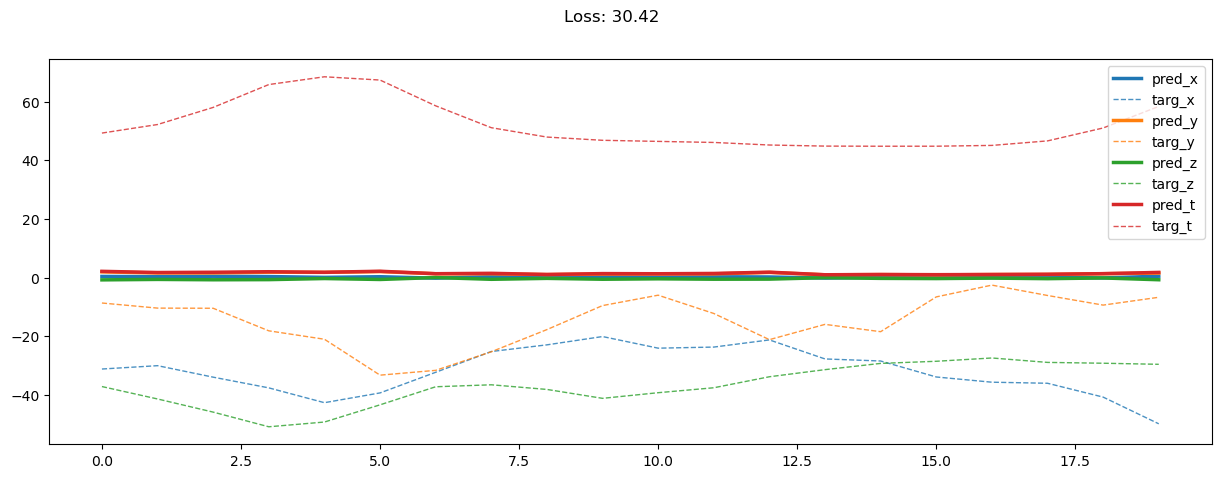

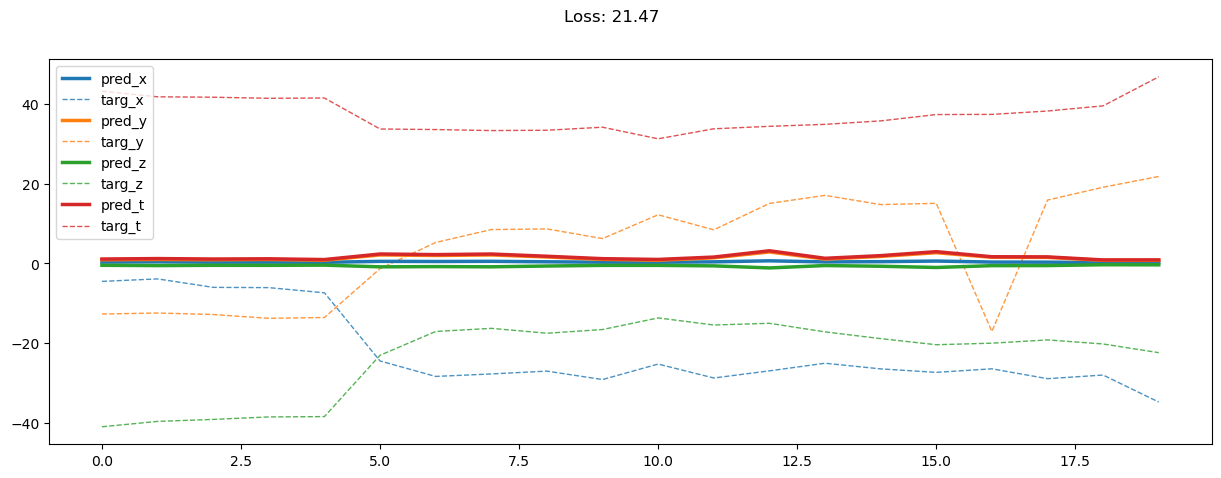

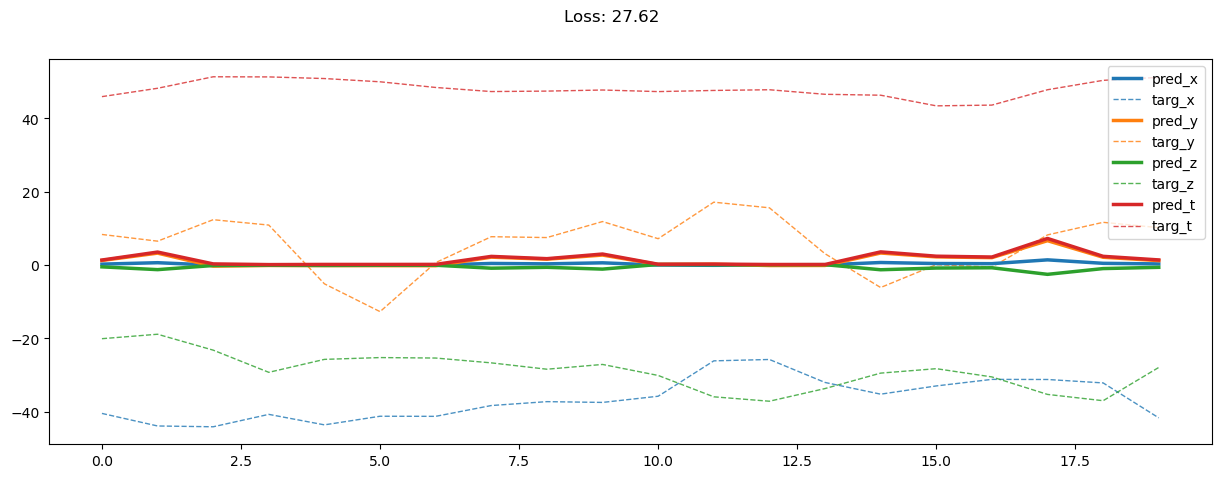

00000: train loss: 117.767, imu loss:  4.416, mag loss: 24.249, div loss:  9.080, slim: 40.501, tlim: 41.010
      train* loss: 118.537, imu loss:  4.393, mag loss: 24.204, div loss:  9.109, slim: 38.991, tlim: 39.463
      valid* loss: 122.248, imu loss:  4.389, mag loss: 26.225, div loss:  3.056, slim: 43.259, tlim: 43.036
00100: train loss:  37.640, imu loss:  3.411, mag loss:  8.646, div loss:  8.423, slim:  1.806, tlim:  3.202
      train* loss:  78.612, imu loss:  3.409, mag loss: 12.932, div loss: 11.973, slim:  7.999, tlim:  9.068
      valid* loss:  69.789, imu loss:  3.327, mag loss:  9.725, div loss:  4.529, slim:  5.950, tlim:  6.977
00200: train loss:  37.254, imu loss:  3.404, mag loss:  8.463, div loss:  8.232, slim:  1.818, tlim:  3.040
      train* loss:  74.525, imu loss:  3.400, mag loss: 11.363, div loss: 11.098, slim:  6.317, tlim:  7.441
      valid* loss:  66.683, imu loss:  3.309, mag loss:  8.080, div loss:  4.242, slim:  4.889, tlim:  5.790
00300: train loss: 

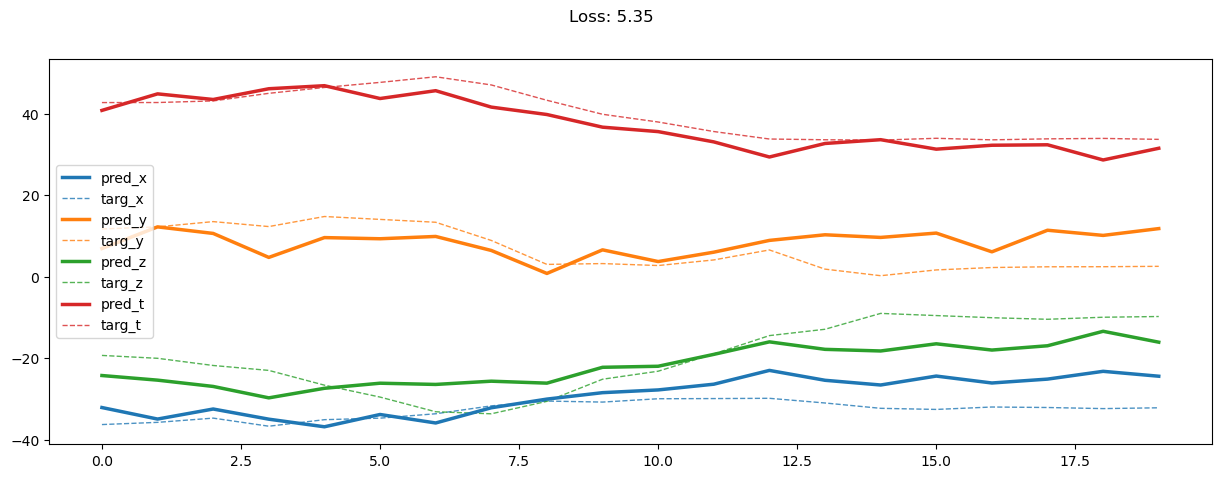

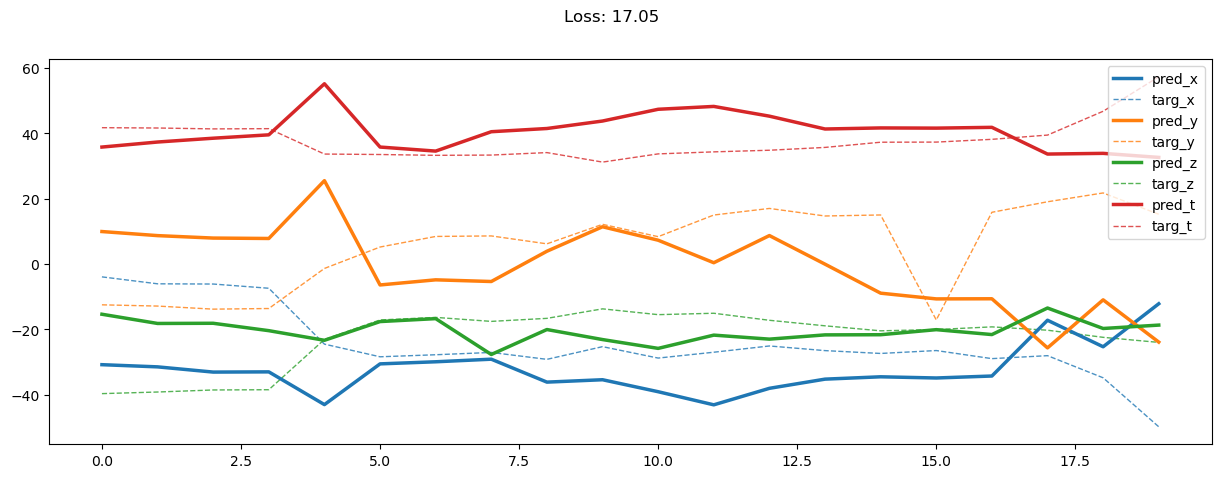

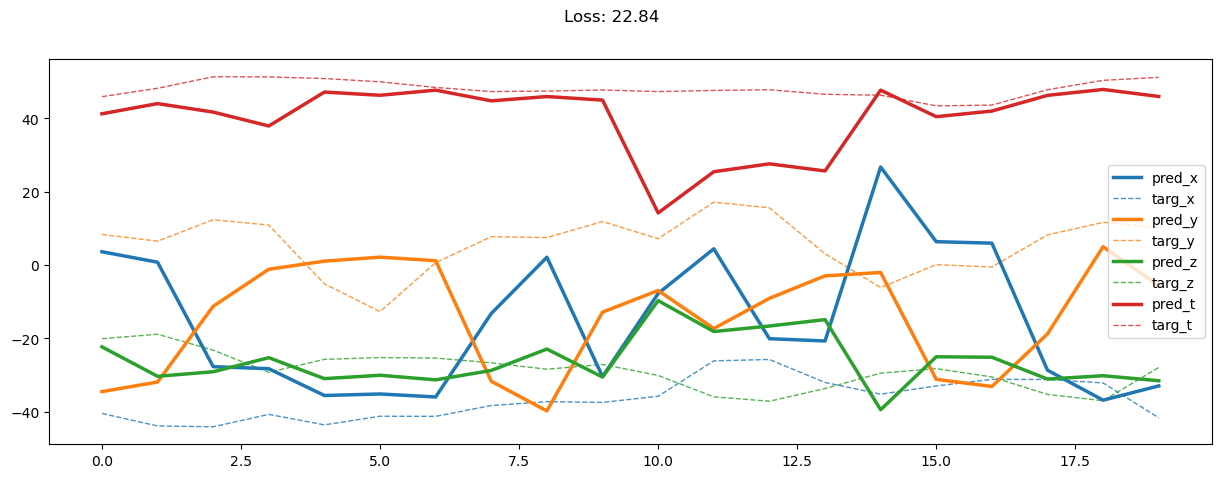

02000: train loss:  25.799, imu loss:  2.899, mag loss:  6.934, div loss:  6.705, slim:  2.442, tlim:  2.324
      train* loss:  91.079, imu loss:  2.869, mag loss: 19.349, div loss: 19.759, slim:  6.910, tlim:  7.832
      valid* loss:  84.454, imu loss:  3.041, mag loss: 18.267, div loss: 10.931, slim:  5.764, tlim:  7.047
02100: train loss:  25.410, imu loss:  2.898, mag loss:  6.869, div loss:  6.695, slim:  2.451, tlim:  2.327
      train* loss:  91.103, imu loss:  2.855, mag loss: 19.295, div loss: 19.793, slim:  6.934, tlim:  7.858
      valid* loss:  85.183, imu loss:  3.041, mag loss: 18.661, div loss: 11.213, slim:  5.864, tlim:  7.087
02200: train loss:  24.961, imu loss:  2.894, mag loss:  6.799, div loss:  6.655, slim:  2.457, tlim:  2.311
      train* loss:  91.568, imu loss:  2.853, mag loss: 19.594, div loss: 19.946, slim:  7.002, tlim:  7.893
      valid* loss:  86.058, imu loss:  3.048, mag loss: 19.050, div loss: 11.512, slim:  6.067, tlim:  7.259
02300: train loss: 

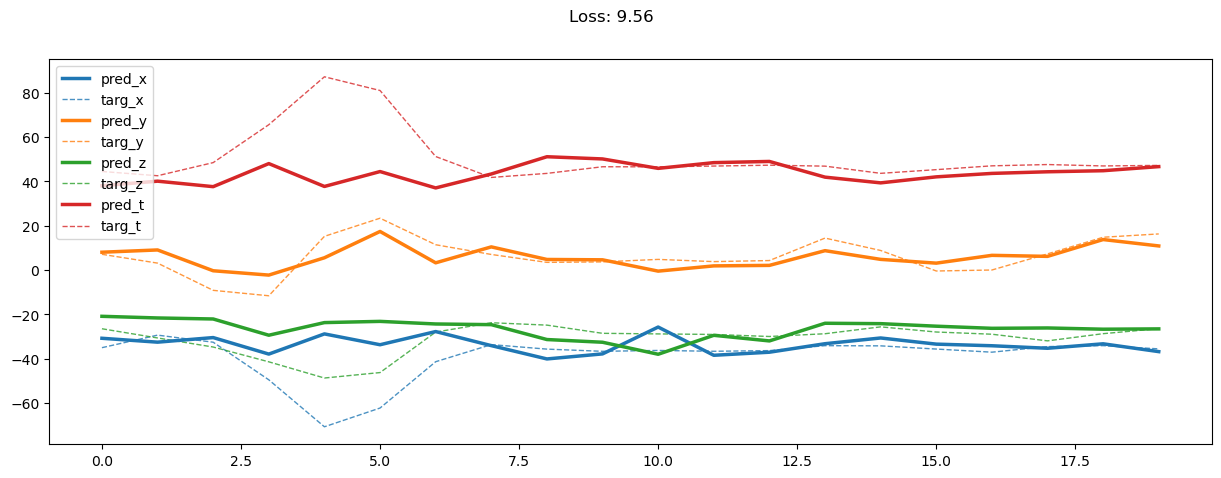

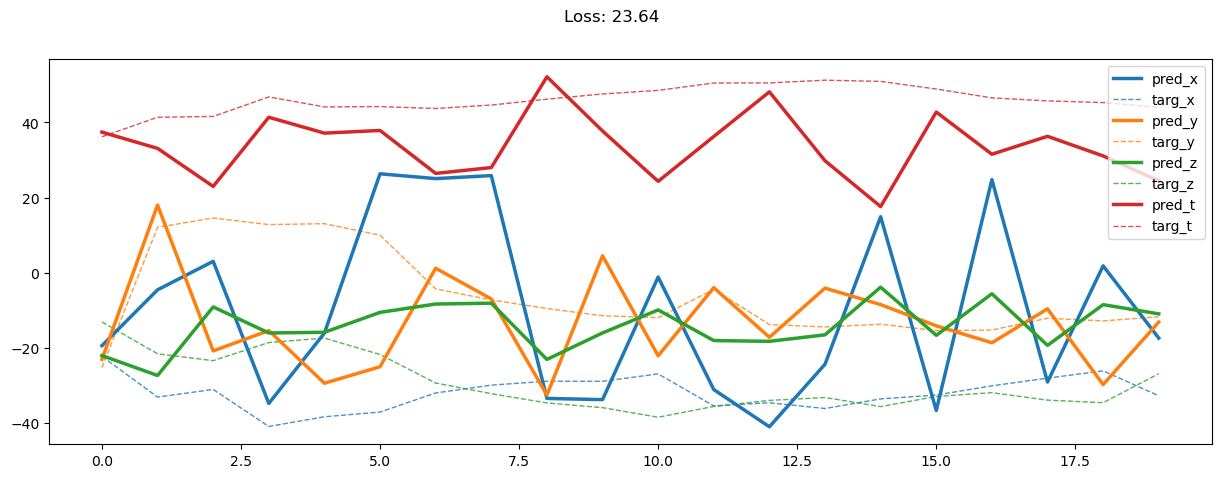

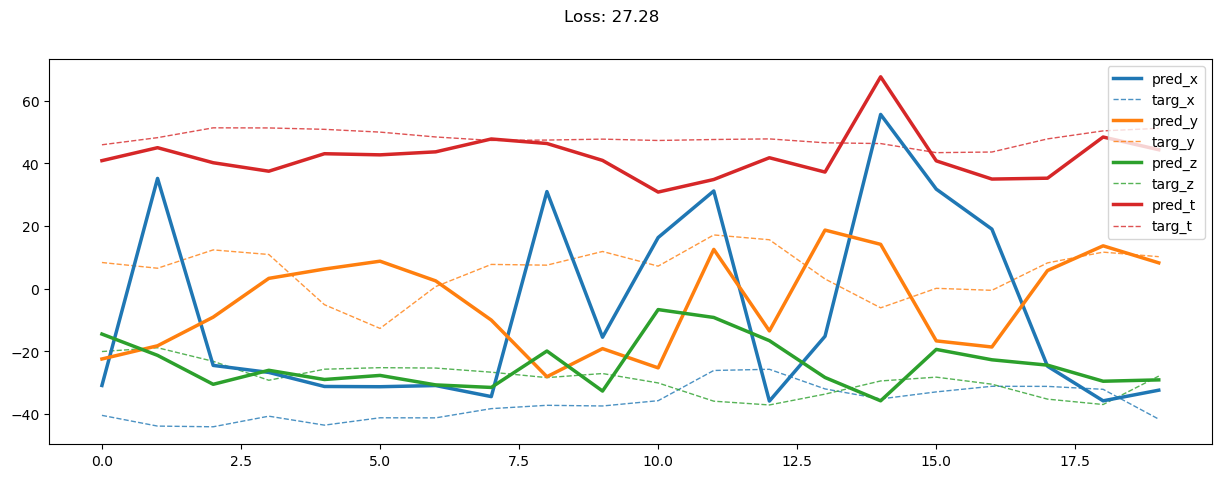

04000: train loss:  20.863, imu loss:  2.807, mag loss:  6.103, div loss:  5.930, slim:  2.507, tlim:  2.219
      train* loss:  91.657, imu loss:  2.755, mag loss: 20.088, div loss: 20.183, slim:  6.548, tlim:  7.322
      valid* loss:  90.206, imu loss:  3.113, mag loss: 20.956, div loss: 13.610, slim:  6.273, tlim:  7.293
04100: train loss:  20.855, imu loss:  2.806, mag loss:  6.065, div loss:  5.900, slim:  2.508, tlim:  2.214
      train* loss:  91.470, imu loss:  2.755, mag loss: 19.975, div loss: 20.142, slim:  6.523, tlim:  7.313
      valid* loss:  90.238, imu loss:  3.110, mag loss: 20.833, div loss: 13.768, slim:  6.268, tlim:  7.297
04200: train loss:  20.638, imu loss:  2.805, mag loss:  6.048, div loss:  5.865, slim:  2.524, tlim:  2.198
      train* loss:  91.318, imu loss:  2.749, mag loss: 20.071, div loss: 19.948, slim:  6.455, tlim:  7.235
      valid* loss:  90.537, imu loss:  3.131, mag loss: 20.959, div loss: 13.889, slim:  6.288, tlim:  7.331
04300: train loss: 

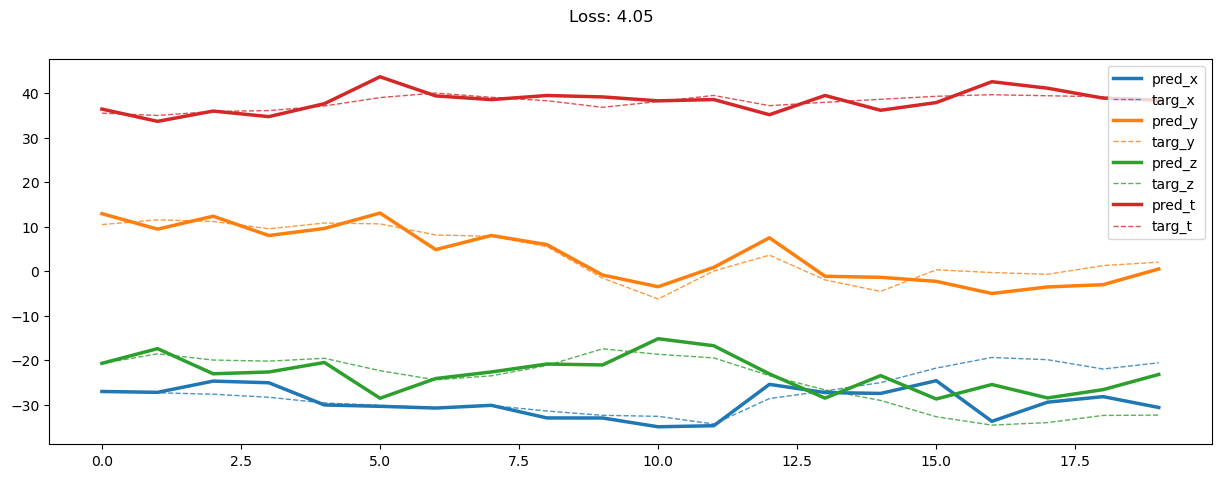

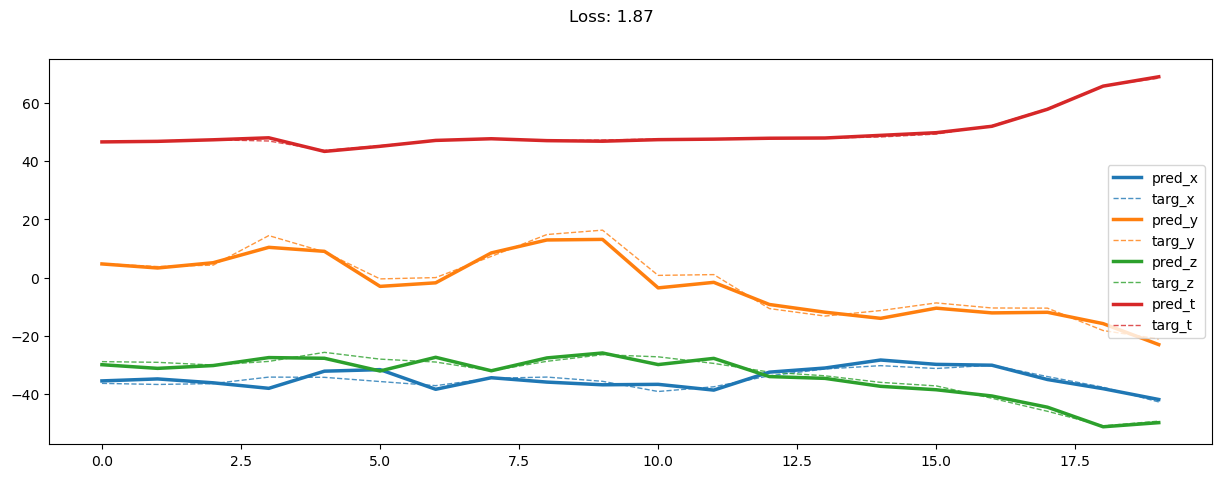

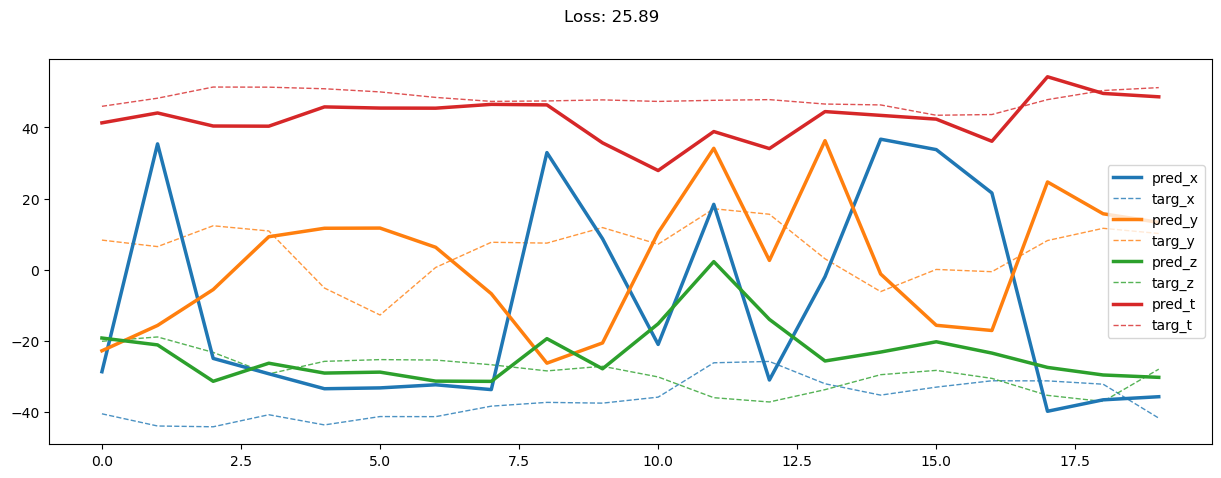

06000: train loss:  19.141, imu loss:  2.729, mag loss:  5.544, div loss:  5.394, slim:  2.599, tlim:  2.110
      train* loss:  91.748, imu loss:  2.661, mag loss: 20.571, div loss: 20.523, slim:  5.859, tlim:  6.690
      valid* loss:  90.717, imu loss:  3.222, mag loss: 21.258, div loss: 14.400, slim:  5.642, tlim:  6.585
06100: train loss:  18.996, imu loss:  2.722, mag loss:  5.536, div loss:  5.369, slim:  2.590, tlim:  2.104
      train* loss:  91.862, imu loss:  2.662, mag loss: 20.577, div loss: 20.584, slim:  5.897, tlim:  6.730
      valid* loss:  90.638, imu loss:  3.227, mag loss: 21.169, div loss: 14.378, slim:  5.646, tlim:  6.619
06200: train loss:  19.101, imu loss:  2.722, mag loss:  5.551, div loss:  5.396, slim:  2.603, tlim:  2.098
      train* loss:  92.542, imu loss:  2.659, mag loss: 20.931, div loss: 20.913, slim:  5.909, tlim:  6.737
      valid* loss:  91.847, imu loss:  3.236, mag loss: 21.928, div loss: 14.775, slim:  5.712, tlim:  6.657
06300: train loss: 

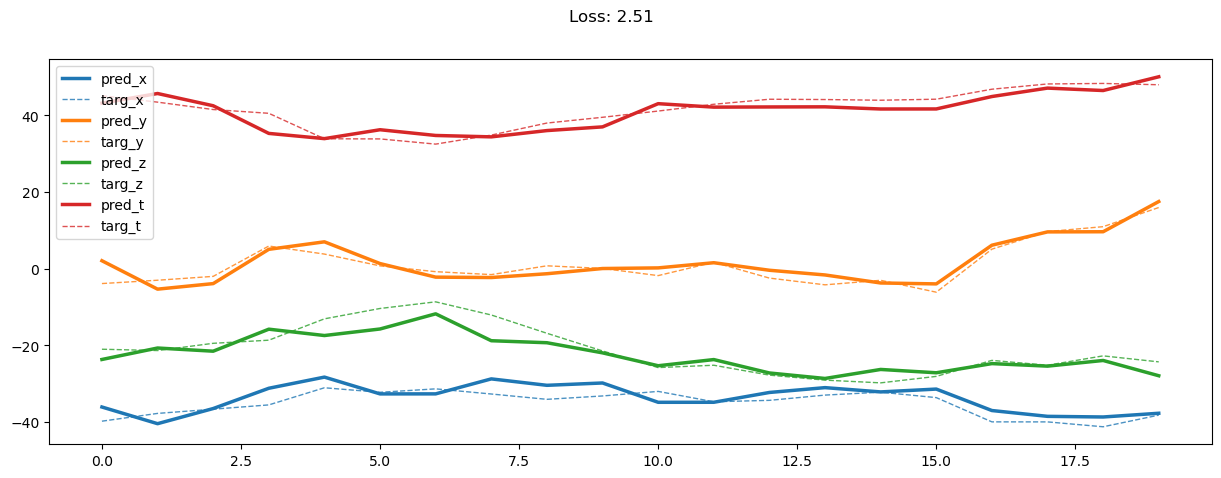

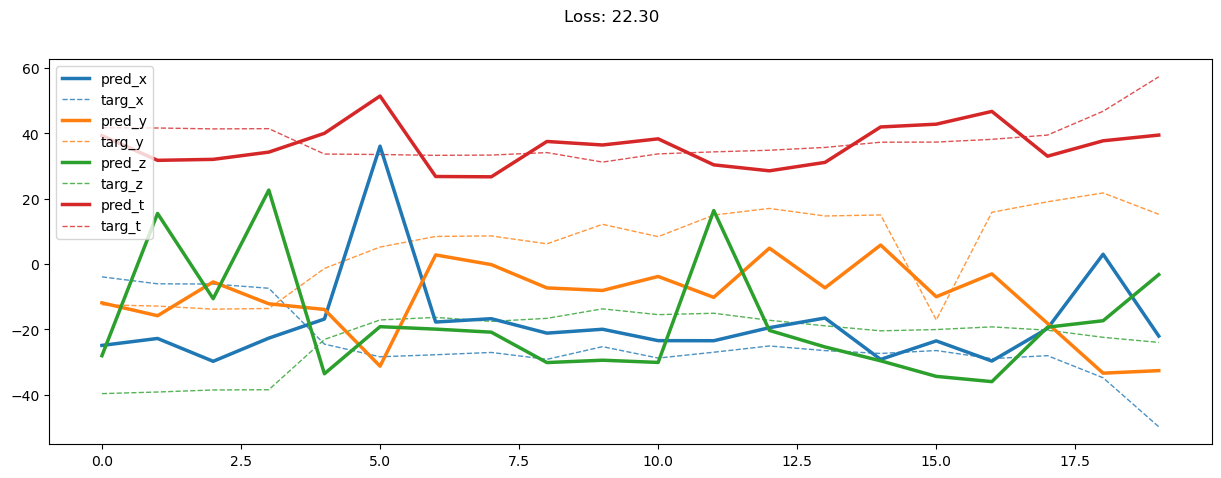

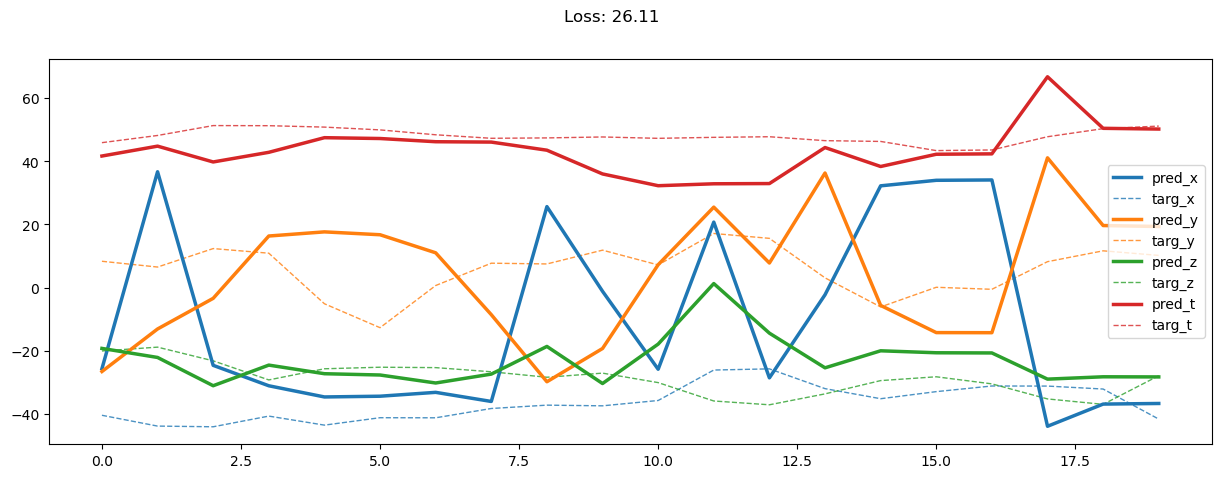

08000: train loss:  18.042, imu loss:  2.666, mag loss:  5.186, div loss:  5.069, slim:  2.653, tlim:  2.027
      train* loss:  94.797, imu loss:  2.587, mag loss: 22.009, div loss: 21.769, slim:  6.294, tlim:  7.123
      valid* loss:  92.808, imu loss:  3.311, mag loss: 22.043, div loss: 15.257, slim:  6.042, tlim:  6.934
08100: train loss:  18.011, imu loss:  2.656, mag loss:  5.175, div loss:  5.039, slim:  2.652, tlim:  2.017
      train* loss:  94.397, imu loss:  2.582, mag loss: 21.905, div loss: 21.560, slim:  6.220, tlim:  7.062
      valid* loss:  91.888, imu loss:  3.288, mag loss: 21.525, div loss: 14.959, slim:  5.934, tlim:  6.860
08200: train loss:  18.025, imu loss:  2.654, mag loss:  5.166, div loss:  5.074, slim:  2.662, tlim:  2.029
      train* loss:  95.211, imu loss:  2.583, mag loss: 22.260, div loss: 21.877, slim:  6.369, tlim:  7.199
      valid* loss:  93.591, imu loss:  3.306, mag loss: 22.415, div loss: 15.539, slim:  6.143, tlim:  7.077
08300: train loss: 

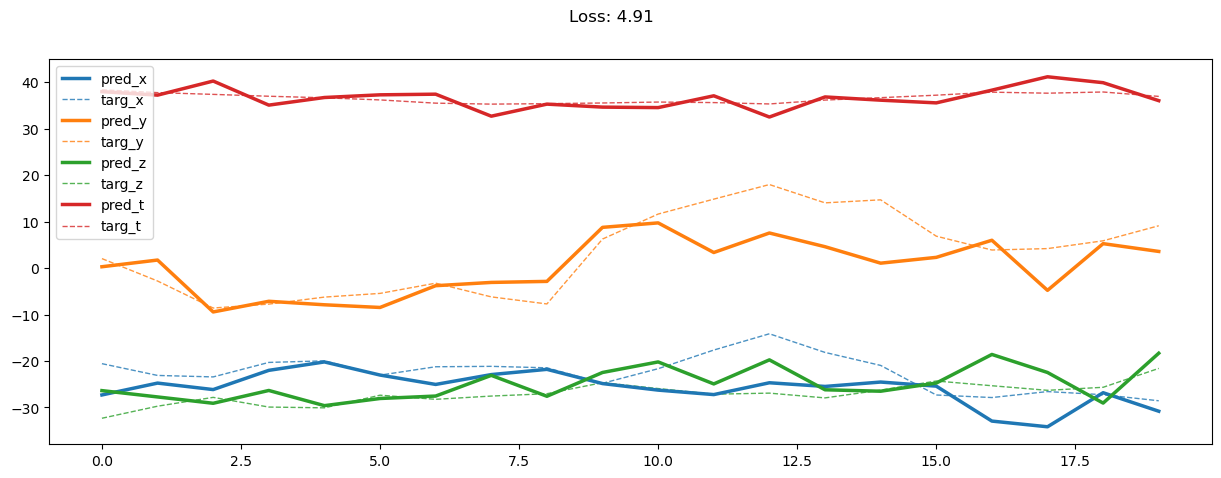

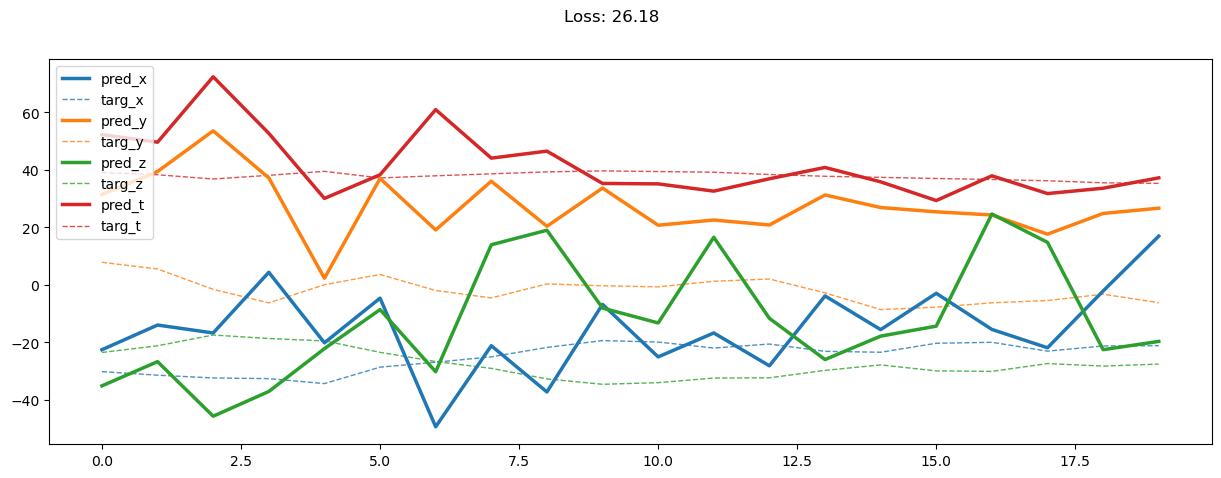

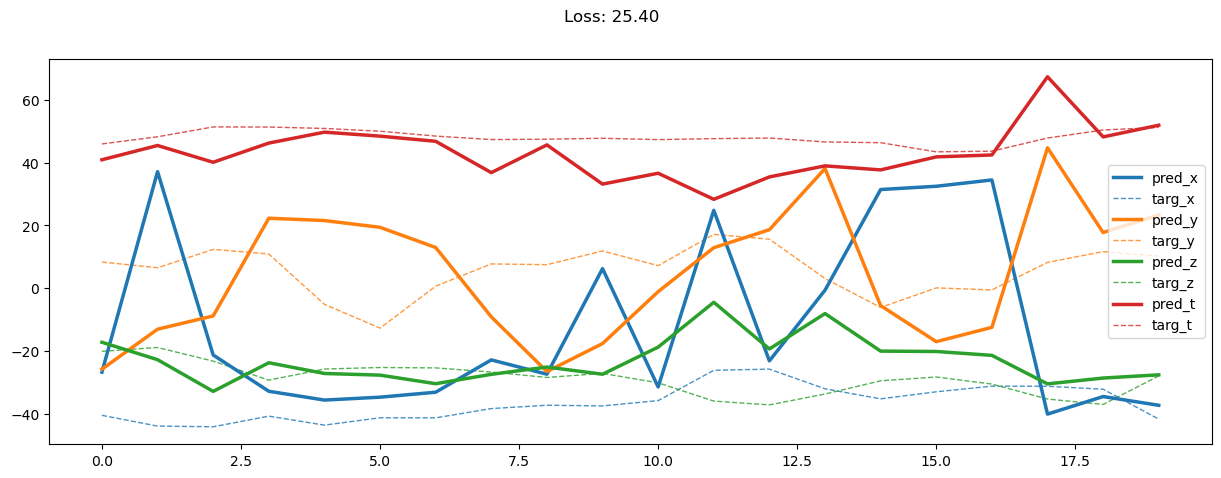

10000: train loss:  17.380, imu loss:  2.614, mag loss:  4.968, div loss:  4.875, slim:  2.700, tlim:  1.966
      train* loss:  96.409, imu loss:  2.525, mag loss: 22.828, div loss: 22.340, slim:  6.546, tlim:  7.437
      valid* loss:  92.960, imu loss:  3.339, mag loss: 21.914, div loss: 15.514, slim:  6.070, tlim:  6.919
10100: train loss:  17.357, imu loss:  2.610, mag loss:  4.973, div loss:  4.882, slim:  2.697, tlim:  1.968
      train* loss:  96.272, imu loss:  2.524, mag loss: 22.794, div loss: 22.167, slim:  6.592, tlim:  7.484
      valid* loss:  92.464, imu loss:  3.346, mag loss: 21.697, div loss: 15.315, slim:  6.002, tlim:  6.824
10200: train loss:  17.487, imu loss:  2.606, mag loss:  4.958, div loss:  4.863, slim:  2.695, tlim:  1.961
      train* loss:  97.035, imu loss:  2.524, mag loss: 23.023, div loss: 22.694, slim:  6.612, tlim:  7.504
      valid* loss:  92.939, imu loss:  3.356, mag loss: 21.910, div loss: 15.508, slim:  6.042, tlim:  6.890
10300: train loss: 

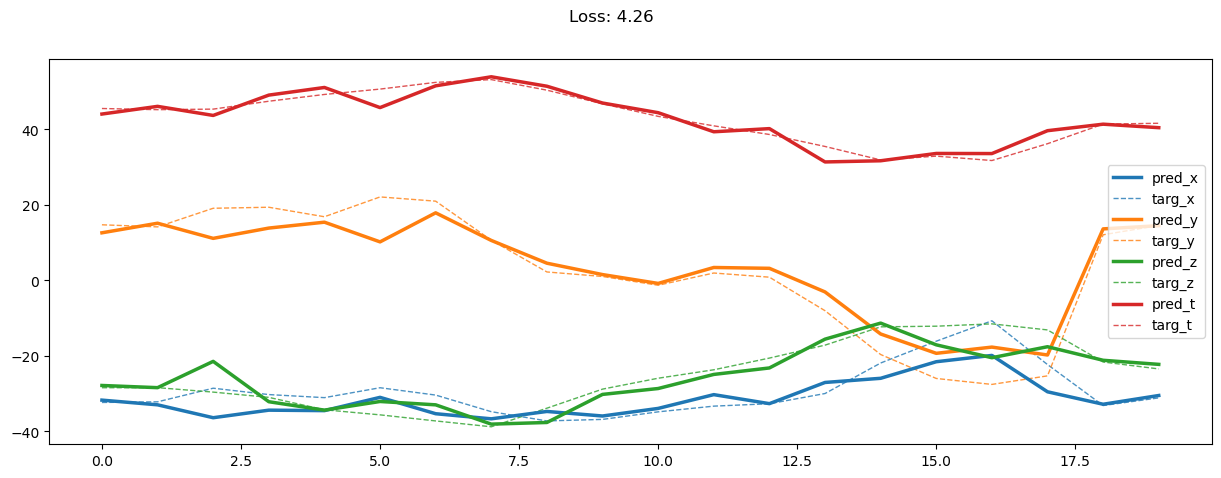

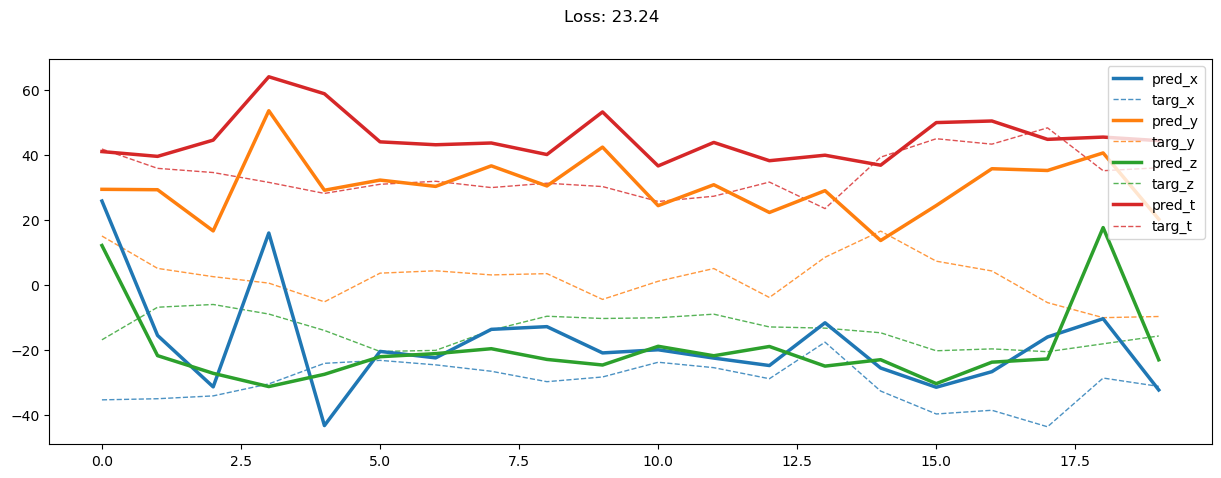

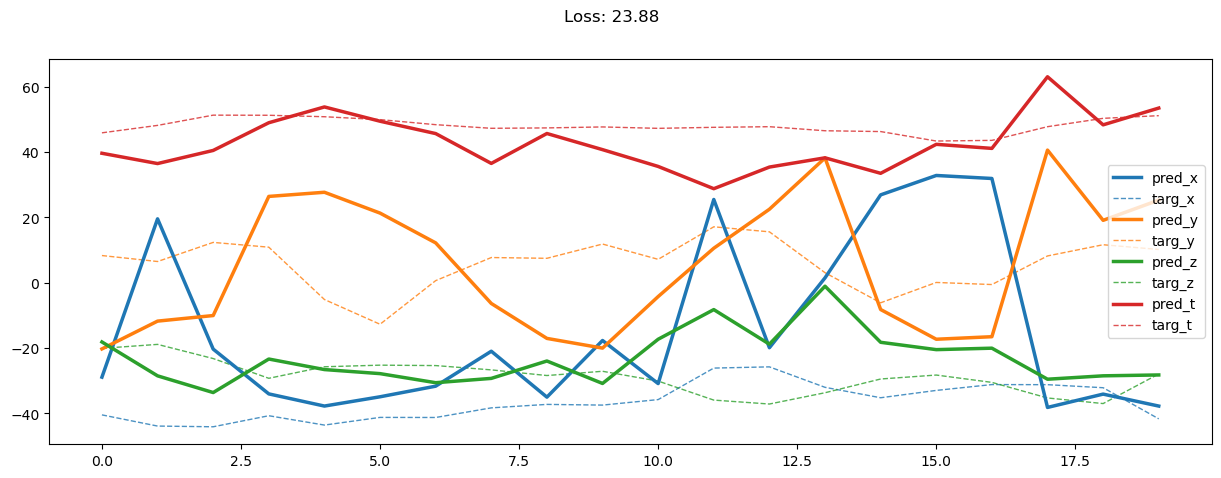

12000: train loss:  16.868, imu loss:  2.567, mag loss:  4.746, div loss:  4.718, slim:  2.735, tlim:  1.908
      train* loss:  97.339, imu loss:  2.475, mag loss: 23.333, div loss: 22.557, slim:  6.790, tlim:  7.696
      valid* loss:  93.087, imu loss:  3.375, mag loss: 22.070, div loss: 15.571, slim:  6.054, tlim:  6.760
12100: train loss:  16.829, imu loss:  2.567, mag loss:  4.752, div loss:  4.711, slim:  2.746, tlim:  1.926
      train* loss:  97.080, imu loss:  2.470, mag loss: 23.227, div loss: 22.505, slim:  6.726, tlim:  7.611
      valid* loss:  93.089, imu loss:  3.380, mag loss: 22.159, div loss: 15.562, slim:  5.993, tlim:  6.670
12200: train loss:  16.843, imu loss:  2.560, mag loss:  4.734, div loss:  4.699, slim:  2.749, tlim:  1.915
      train* loss:  97.808, imu loss:  2.474, mag loss: 23.547, div loss: 22.785, slim:  6.848, tlim:  7.750
      valid* loss:  93.752, imu loss:  3.397, mag loss: 22.464, div loss: 15.807, slim:  6.062, tlim:  6.774
12300: train loss: 

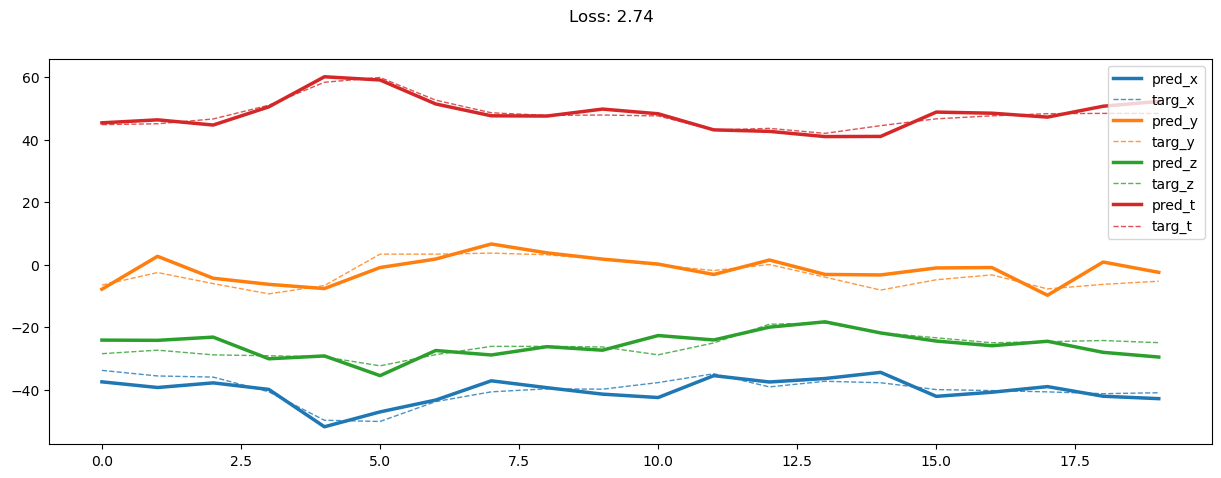

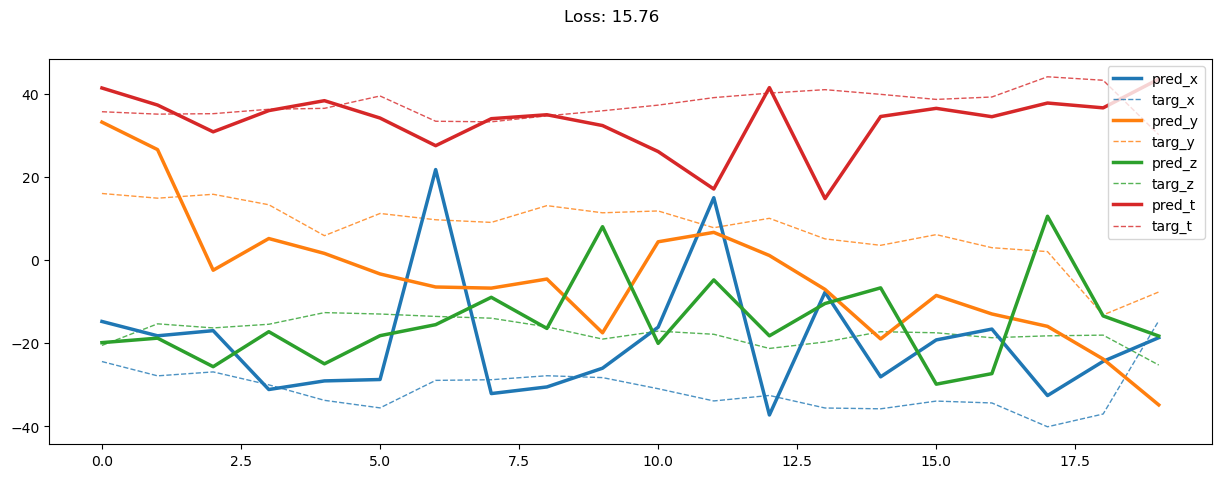

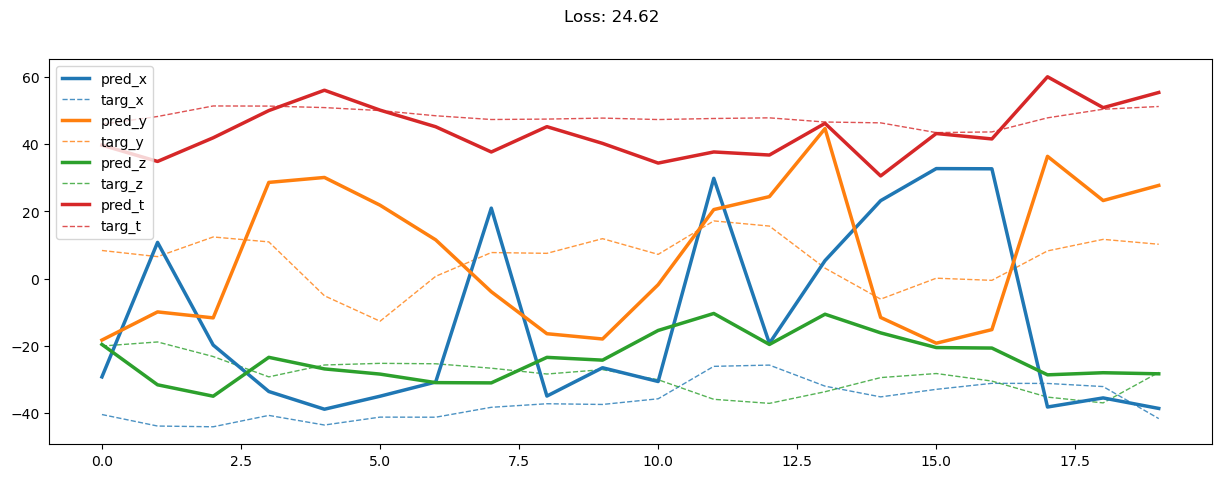

14000: train loss:  16.526, imu loss:  2.541, mag loss:  4.622, div loss:  4.600, slim:  2.770, tlim:  1.891
      train* loss:  98.528, imu loss:  2.452, mag loss: 23.896, div loss: 22.996, slim:  7.044, tlim:  7.909
      valid* loss:  94.381, imu loss:  3.401, mag loss: 22.848, div loss: 15.903, slim:  6.328, tlim:  6.878
14100: train loss:  16.513, imu loss:  2.542, mag loss:  4.651, div loss:  4.625, slim:  2.766, tlim:  1.888
      train* loss:  98.064, imu loss:  2.440, mag loss: 23.733, div loss: 22.731, slim:  7.010, tlim:  7.891
      valid* loss:  93.984, imu loss:  3.408, mag loss: 22.577, div loss: 15.802, slim:  6.292, tlim:  6.848
14200: train loss:  16.494, imu loss:  2.538, mag loss:  4.622, div loss:  4.599, slim:  2.772, tlim:  1.887
      train* loss:  98.353, imu loss:  2.440, mag loss: 23.745, div loss: 22.971, slim:  7.035, tlim:  7.918
      valid* loss:  93.875, imu loss:  3.407, mag loss: 22.548, div loss: 15.849, slim:  6.150, tlim:  6.728
14300: train loss: 

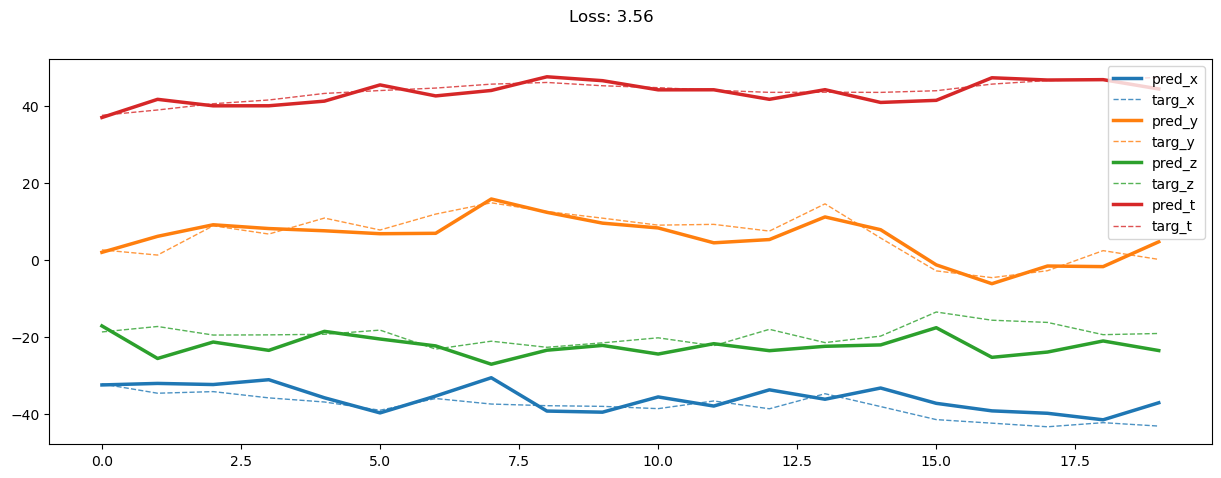

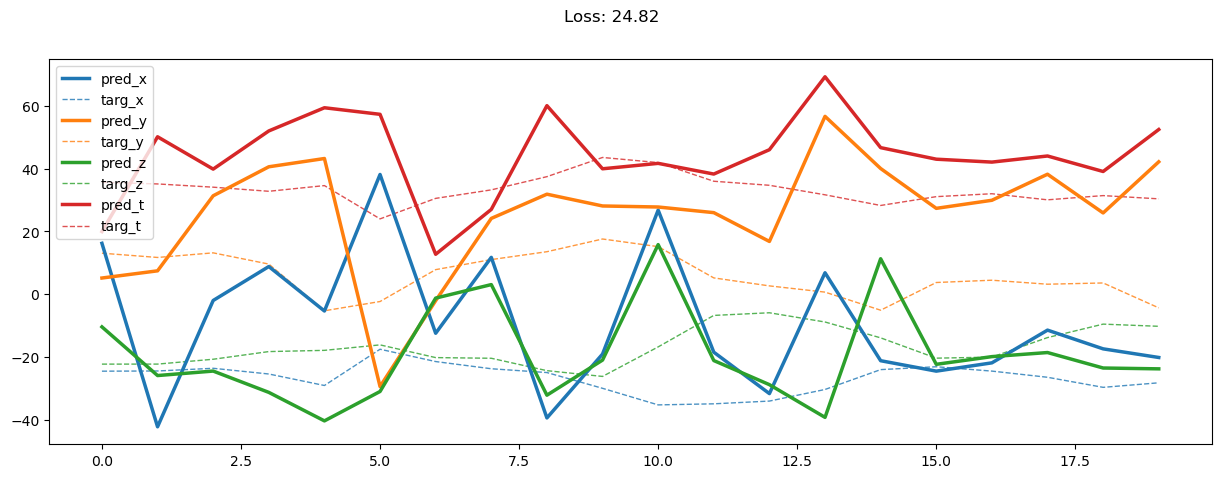

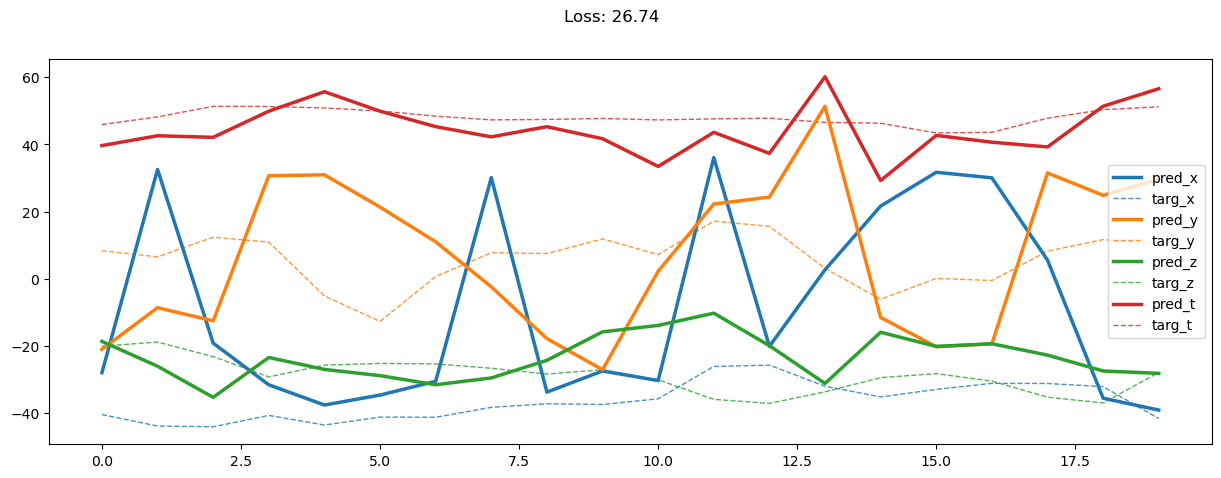

16000: train loss:  16.249, imu loss:  2.526, mag loss:  4.561, div loss:  4.523, slim:  2.785, tlim:  1.852
      train* loss:  98.378, imu loss:  2.420, mag loss: 23.853, div loss: 22.952, slim:  6.989, tlim:  7.880
      valid* loss:  94.765, imu loss:  3.409, mag loss: 23.077, div loss: 16.110, slim:  6.288, tlim:  6.814
16100: train loss:  16.204, imu loss:  2.524, mag loss:  4.542, div loss:  4.507, slim:  2.794, tlim:  1.849
      train* loss:  98.375, imu loss:  2.420, mag loss: 23.836, div loss: 22.956, slim:  6.982, tlim:  7.898
      valid* loss:  94.034, imu loss:  3.429, mag loss: 22.591, div loss: 15.884, slim:  6.266, tlim:  6.768
16200: train loss:  16.155, imu loss:  2.523, mag loss:  4.560, div loss:  4.548, slim:  2.812, tlim:  1.851
      train* loss:  98.692, imu loss:  2.428, mag loss: 24.001, div loss: 22.995, slim:  7.038, tlim:  7.956
      valid* loss:  94.252, imu loss:  3.432, mag loss: 22.684, div loss: 15.969, slim:  6.304, tlim:  6.803
16300: train loss: 

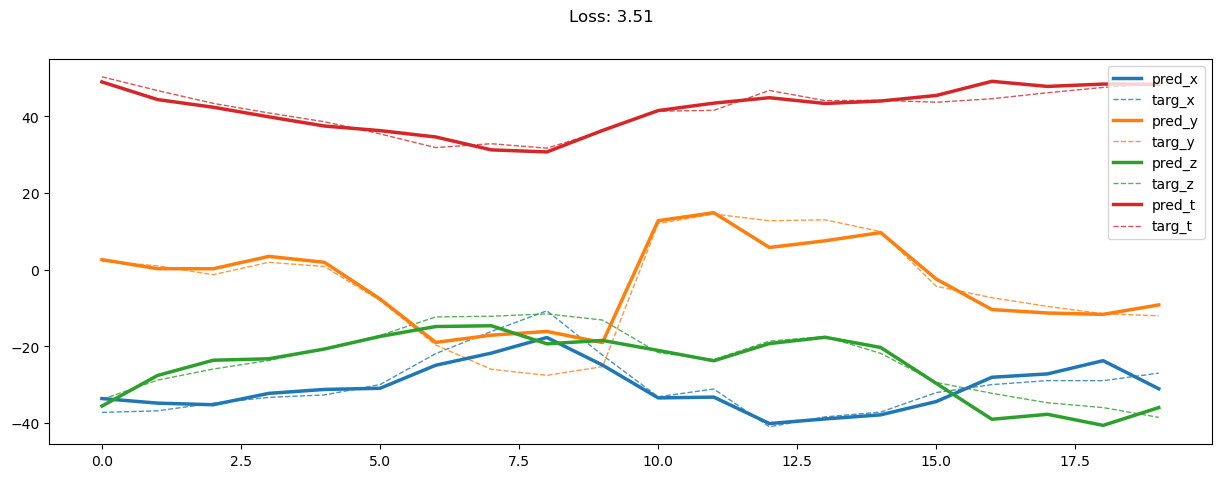

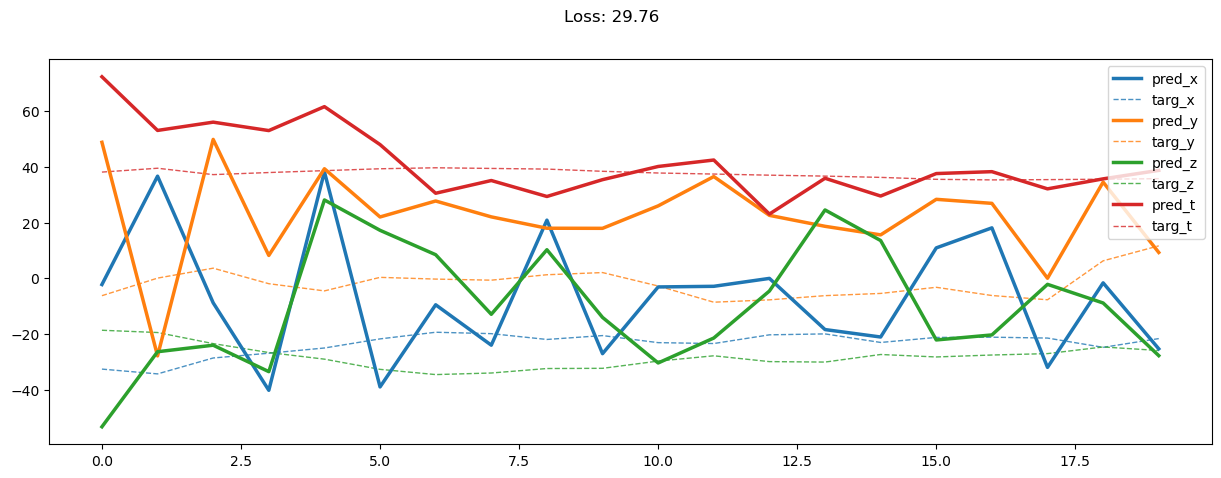

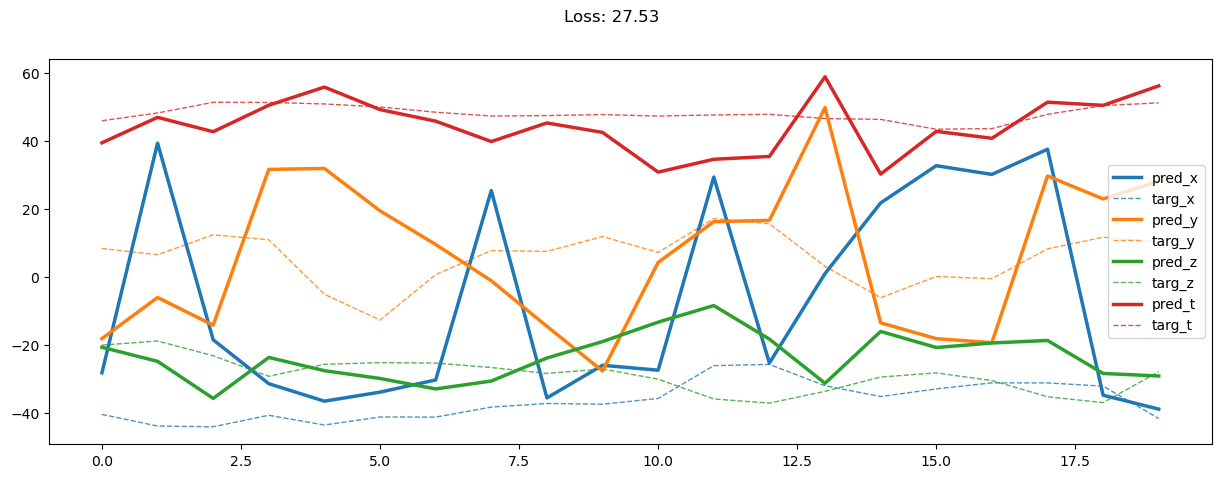

18000: train loss:  15.939, imu loss:  2.507, mag loss:  4.466, div loss:  4.442, slim:  2.814, tlim:  1.827
      train* loss:  97.774, imu loss:  2.399, mag loss: 23.599, div loss: 22.654, slim:  6.965, tlim:  7.865
      valid* loss:  95.279, imu loss:  3.427, mag loss: 23.160, div loss: 16.322, slim:  6.579, tlim:  6.984
18100: train loss:  15.945, imu loss:  2.505, mag loss:  4.471, div loss:  4.440, slim:  2.824, tlim:  1.827
      train* loss:  98.132, imu loss:  2.396, mag loss: 23.757, div loss: 22.801, slim:  7.001, tlim:  7.913
      valid* loss:  95.227, imu loss:  3.448, mag loss: 23.050, div loss: 16.351, slim:  6.541, tlim:  7.006
18200: train loss:  15.861, imu loss:  2.497, mag loss:  4.467, div loss:  4.428, slim:  2.825, tlim:  1.822
      train* loss:  97.815, imu loss:  2.395, mag loss: 23.550, div loss: 22.704, slim:  6.990, tlim:  7.900
      valid* loss:  94.932, imu loss:  3.432, mag loss: 22.765, div loss: 16.344, slim:  6.537, tlim:  7.024
18300: train loss: 

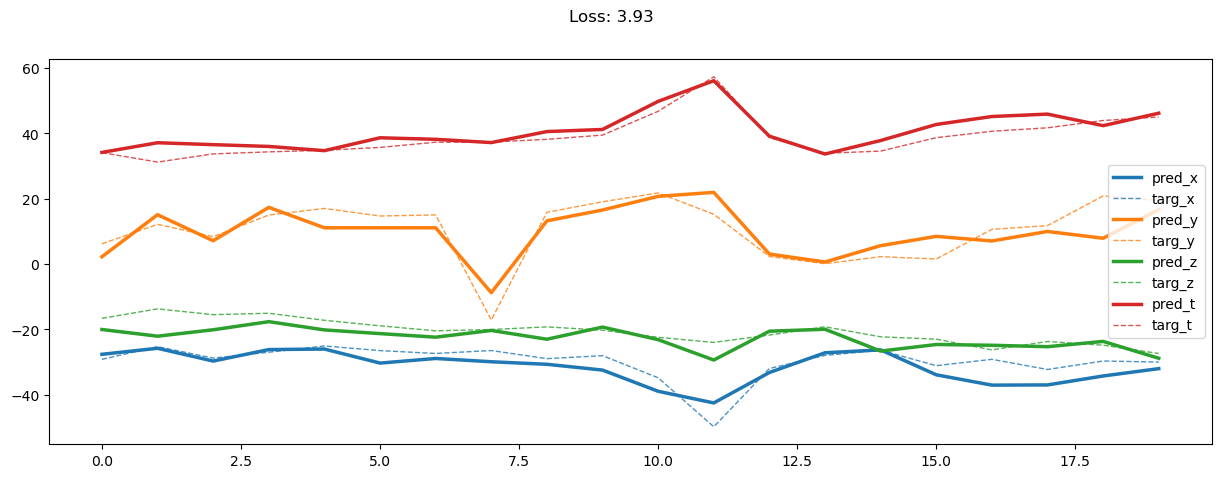

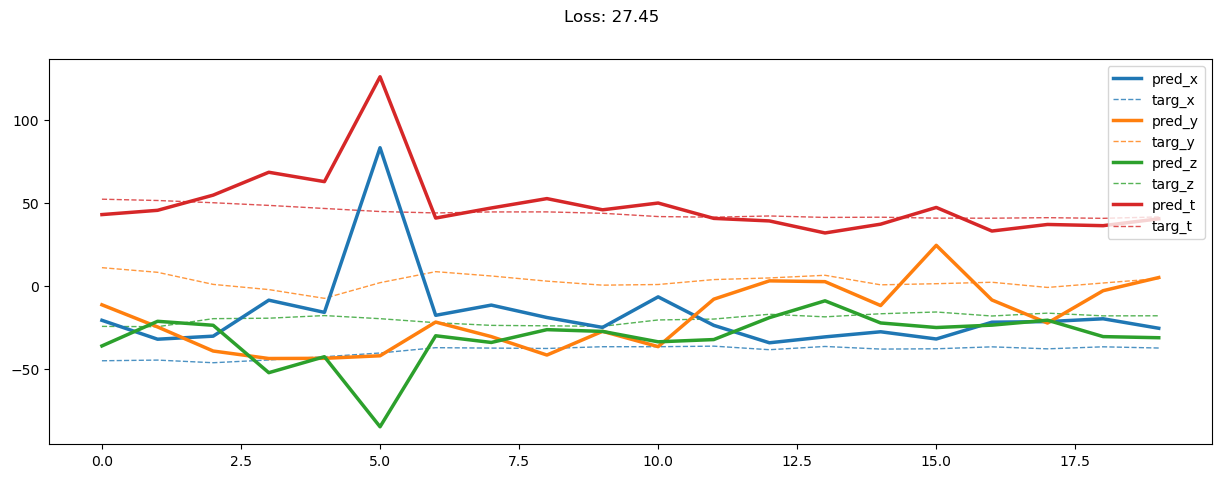

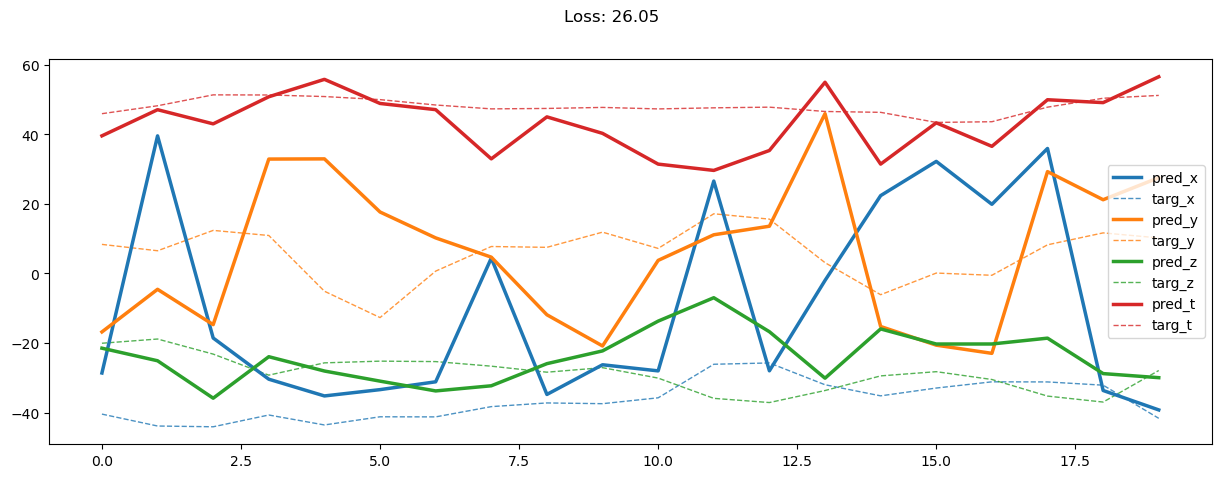

20000: train loss:  15.702, imu loss:  2.487, mag loss:  4.422, div loss:  4.390, slim:  2.837, tlim:  1.794
      train* loss:  97.280, imu loss:  2.364, mag loss: 23.425, div loss: 22.378, slim:  6.927, tlim:  7.860
      valid* loss:  95.277, imu loss:  3.428, mag loss: 22.899, div loss: 16.545, slim:  6.560, tlim:  7.036


In [26]:
EPOCH = 20000
draw = False

for epoch in range(EPOCH+1):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    draw = ((epoch) % 2000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw, epoch / EPOCH)
    
    if epoch % 100 == 0:
        ttrain_loss, ttrain_imu_loss, ttrain_mag_loss, tt_d1_loss, ttlim_loss = evalute(train_loader, draw)
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>7.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5} train* loss: {ttrain_loss:>7.3f}, imu loss: {ttrain_imu_loss:>6.3f}, mag loss: {ttrain_mag_loss:>6.3f}, div loss: {tt_d1_loss:>6.3f}, slim: {ttlim_loss[0]:>6.3f}, tlim: {ttlim_loss[1]:>6.3f}\n' +
              f'{"":>5} valid* loss: {valid_loss:>7.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(3030, 4) (3030, 3) (3030,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    38.98    25.87    21.91    28.92
         pocket loss:    25.59    26.06    25.86    25.84
          swing loss:    17.41    21.52    17.27    18.73
          dummy loss:     1.95     2.28     1.83     2.02
         target loss:    26.53    21.77    14.41    20.90
        average loss:    22.09    19.50    16.26    19.28


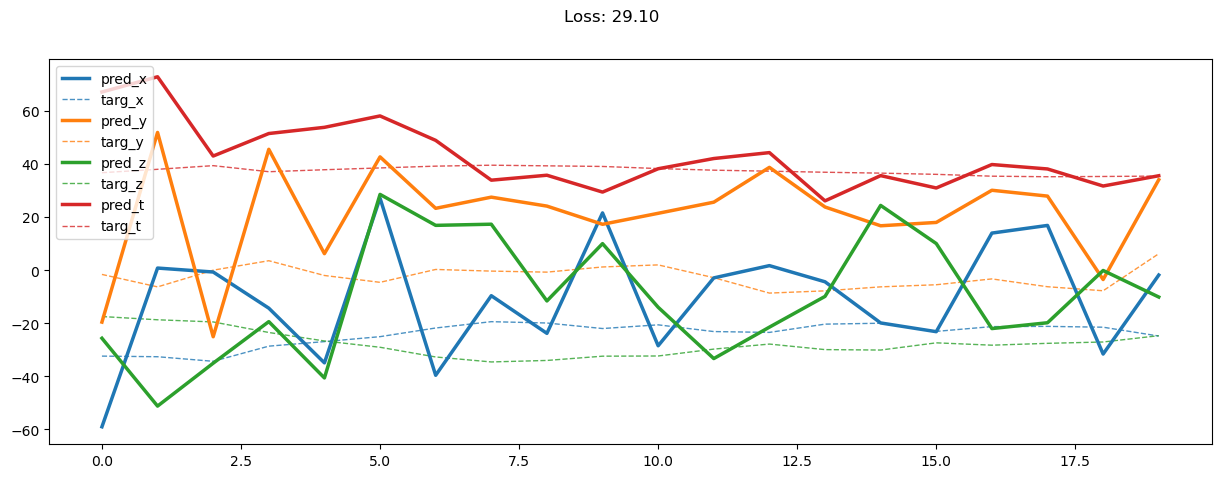

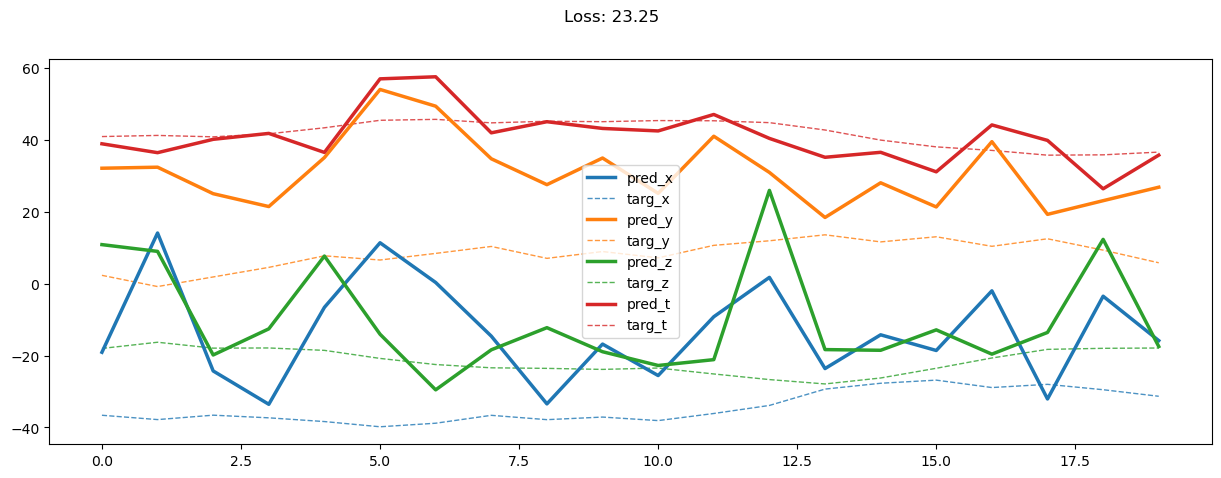

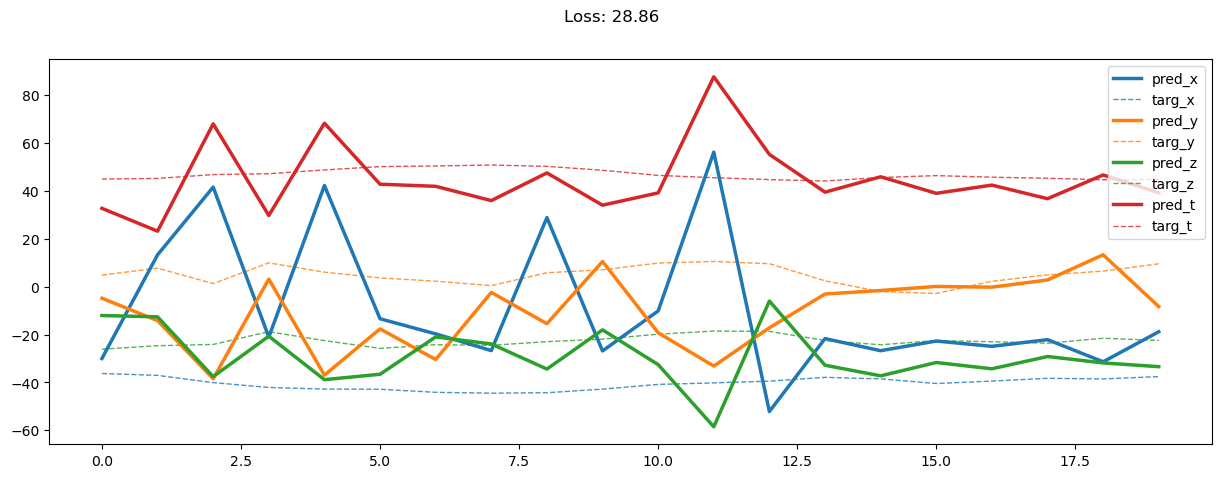

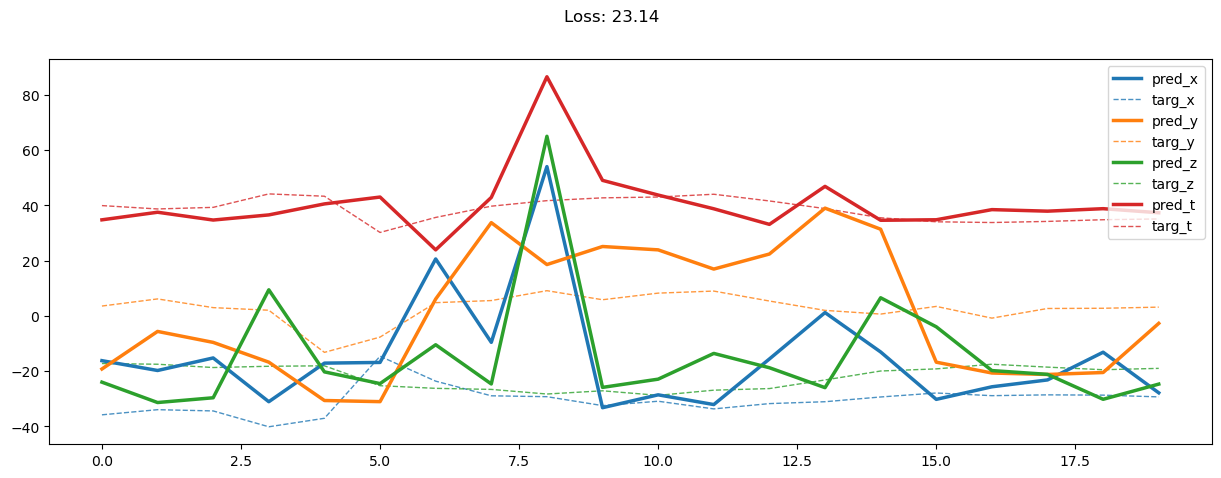

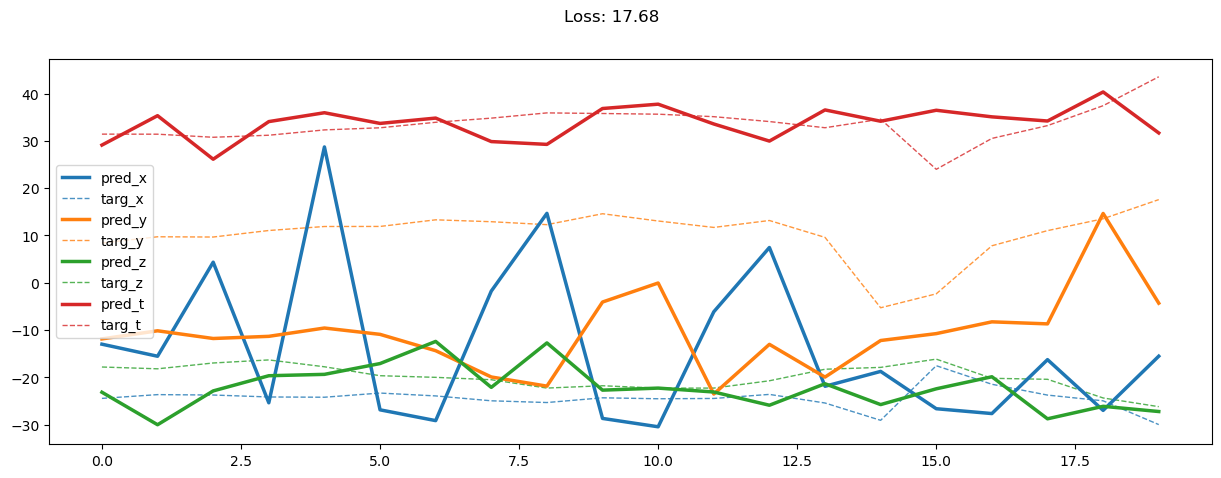

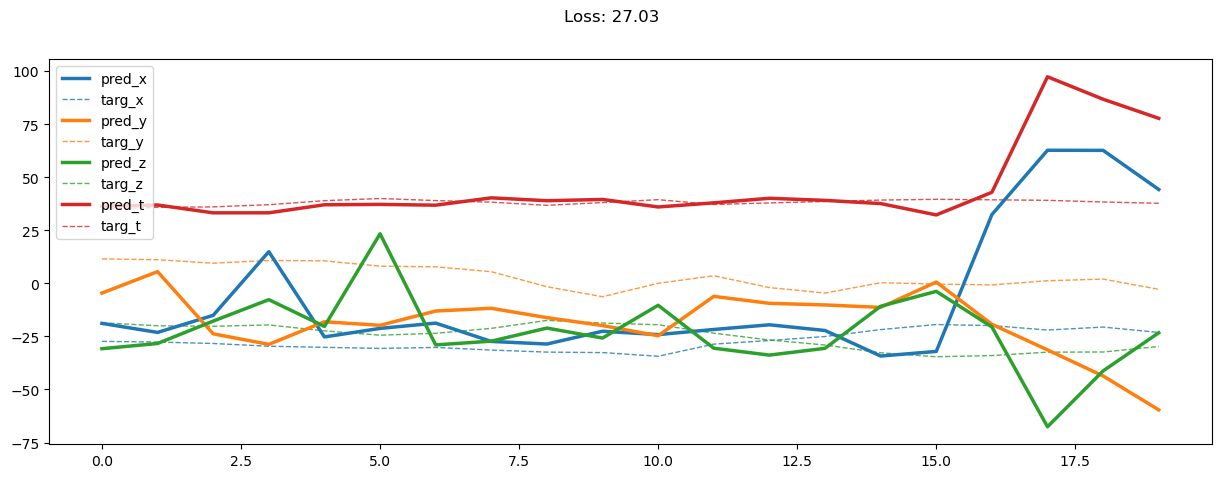

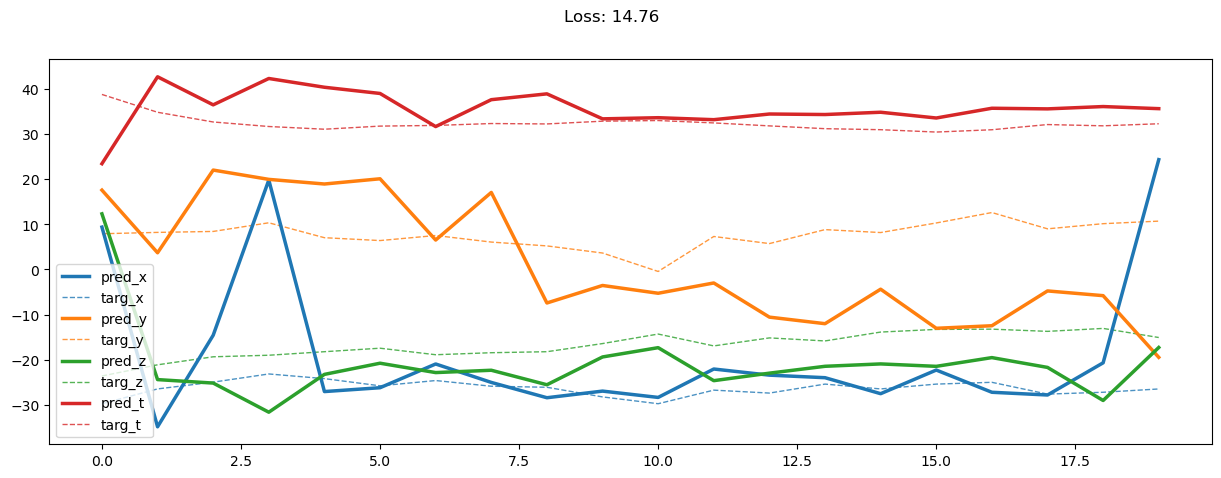

In [27]:
show_result(model, train_loader)

(340, 4) (340, 3) (340,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    25.87    17.58    22.11    21.85
         pocket loss:    24.10    28.12    27.69    26.64
          swing loss:    19.17    21.84    27.54    22.85
          dummy loss:    15.24    10.52     4.89    10.22
         target loss:    33.23    24.53    11.10    22.95
        average loss:    23.52    20.52    18.67    20.90


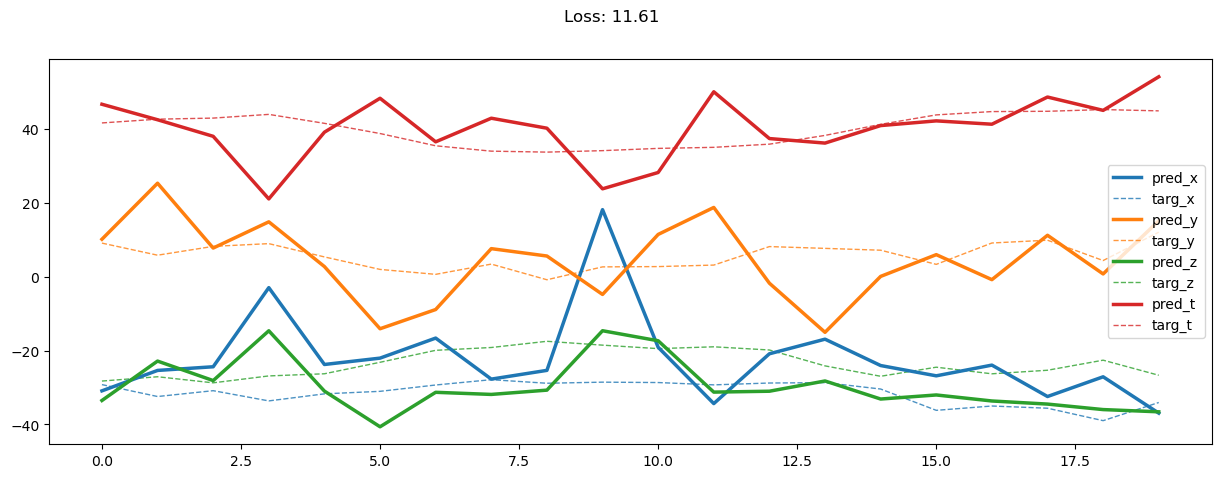

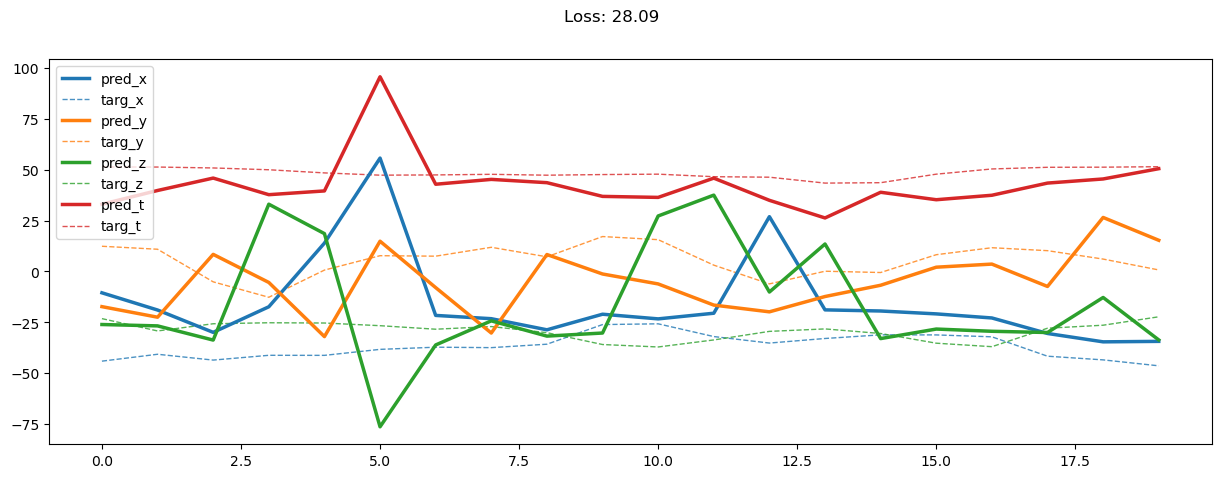

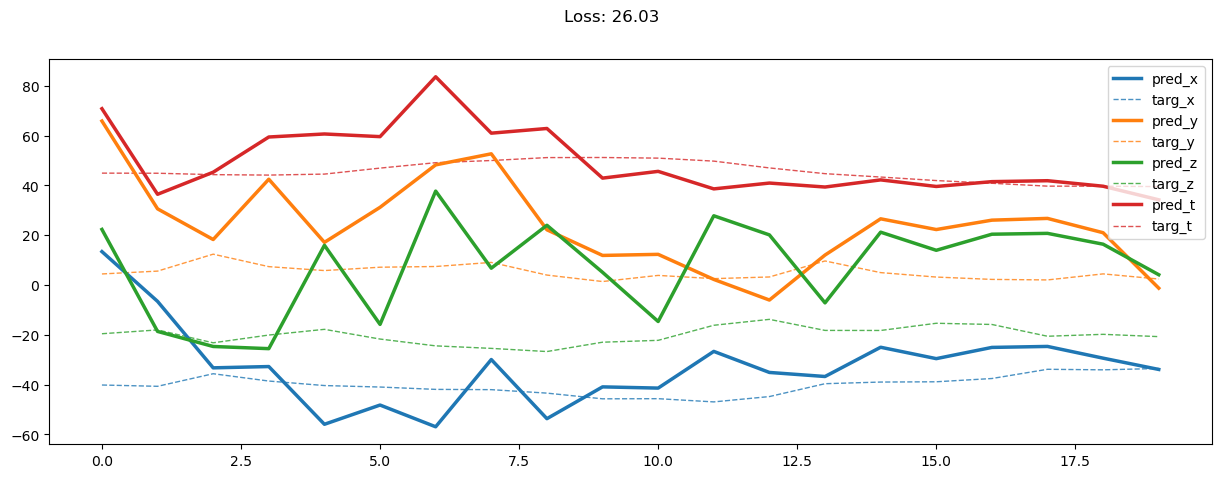

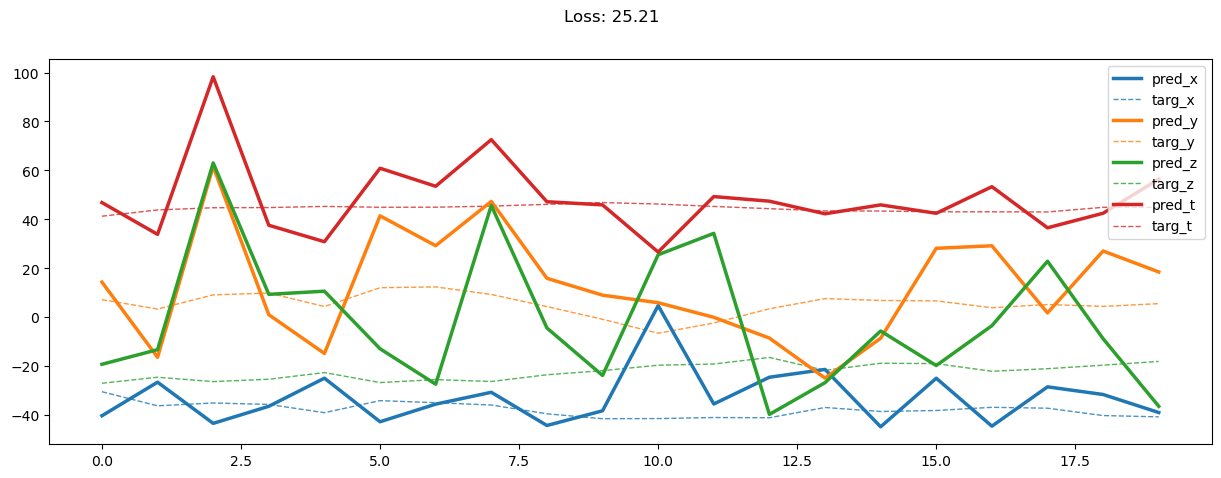

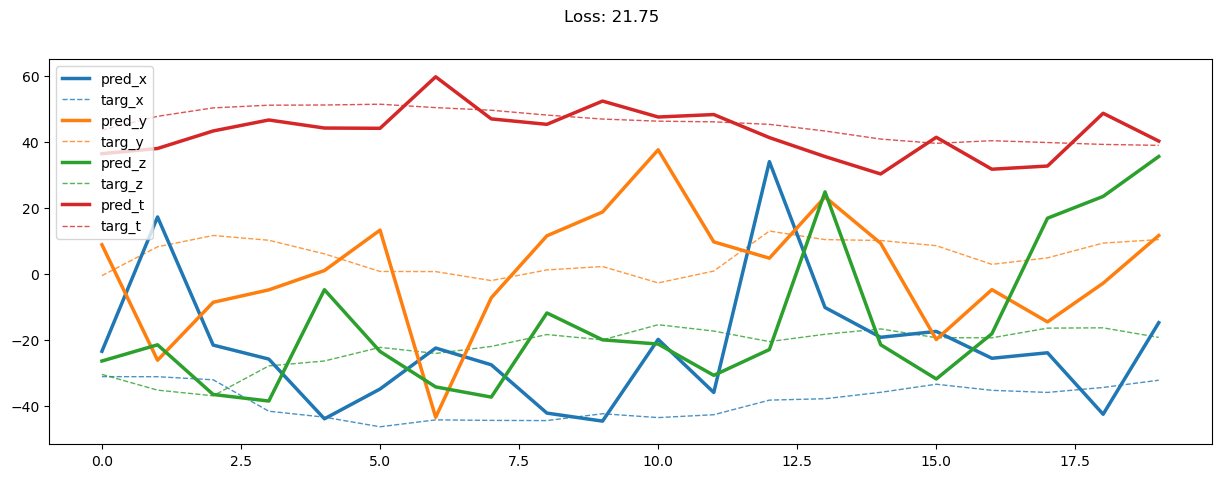

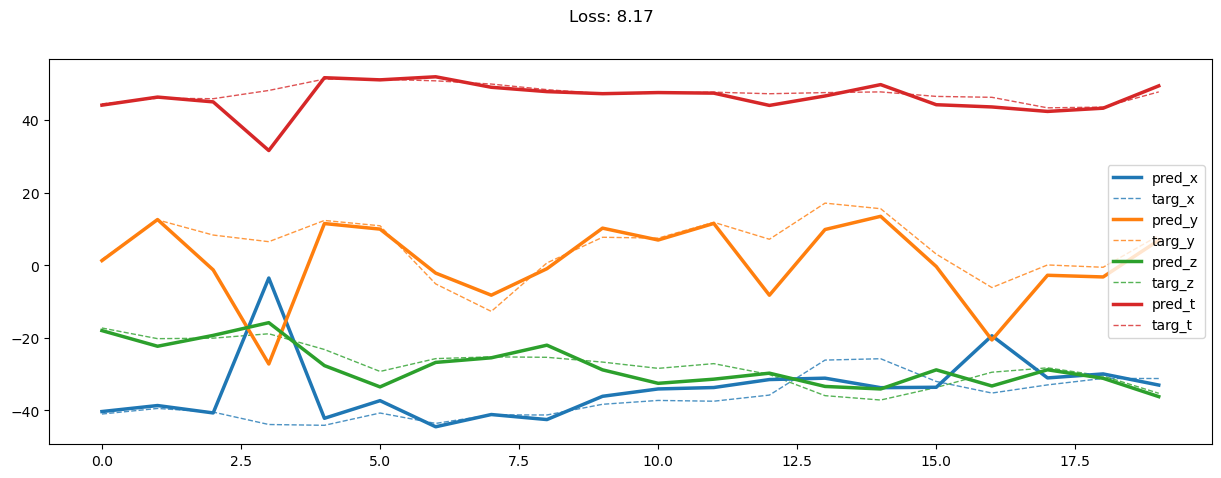

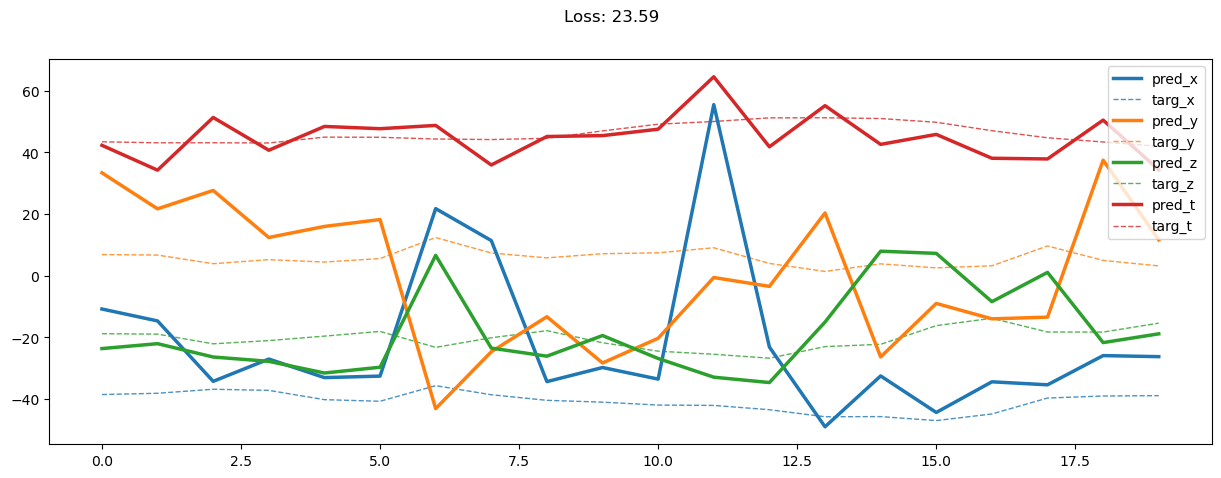

In [28]:
show_result(model, valid_loader, step=50)